<a href="https://colab.research.google.com/github/arbiter1elegantiae/kaf-nets/blob/master/PGD_attack_kafnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install --upgrade tf-nightly

     |████████████████████████████████| 322.8MB 48kB/s 
     |████████████████████████████████| 460kB 37.9MB/s 
     |████████████████████████████████| 6.5MB 37.8MB/s 


In [ ]:
!pip install tf-nightly==2.3.0-dev20200521

     |████████████████████████████████| 523.3MB 34kB/s 
     |████████████████████████████████| 460kB 44.7MB/s 
     |████████████████████████████████| 6.5MB 40.4MB/s 


In [ ]:
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

import activationsf

In [ ]:
tf.version.VERSION

'2.3.0-dev20200521'

In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 655kB 7.3MB/s 
     |████████████████████████████████| 7.1MB 19.2MB/s 
     |████████████████████████████████| 20.8MB 1.3MB/s 
     |████████████████████████████████| 235kB 46.4MB/s 
     |████████████████████████████████| 747kB 42.3MB/s 
ERROR: chainer 6.5.0 has requirement typing-extensions<=3.6.6, but you'll have typing-extensions 3.7.4.2 which is incompatible.
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
  Found existing installation: typing-extensions 3.6.6
    Uninstalling typing-extensions-3.6.6:
      Successfully uninstalled typing-extensions-3.6.6


In [ ]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/ 255.0, x_test/ 255.0

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
# Load robust model trained as https://arxiv.org/abs/2001.03994
#!unzip /content/kaf_cnn_robust_fbf.zip

rob_kaf_cnn = tf.keras.models.load_model('/content/content/kaf_cnn_robust_fbf', custom_objects={'Kaf':activationsf.Kaf})

In [ ]:
# Evaluation on vanilla test/train set
rob_kaf_cnn.evaluate(x_train, y_train, batch_size=128)
rob_kaf_cnn.evaluate(x_test, y_test, batch_size=128)

79/79 [==============================] - 6s 75ms/step - loss: 1.2221 - accuracy: 0.6054


[1.2221406698226929, 0.605400025844574]

In [ ]:
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import ProjectedGradientDescent

# Wrap the model in a TensorFlowV2Classifier object
rob_kaf_cnn_art = TensorFlowV2Classifier(model=rob_kaf_cnn, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), clip_values=(0, 1))

In [ ]:
# Set up a PGD attack w/ parameters as described in FBF ref paper
pgd = ProjectedGradientDescent(estimator= rob_kaf_cnn_art, eps= 8/255, eps_step=2/255, max_iter=50, num_random_init=10, norm=np.inf)

In [ ]:
# If loaded, every output of subsequent cell execution will include the time in min and sec it took to execute it.
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=027a22f3c06ae0e8f5fc4d3fee66727722c5f9a8e48489d08324bf66d320fc9c
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [ ]:
test_sample_ids = np.random.randint(10000, size=200)
x_test_sample = x_test[test_sample_ids, :, :, :]
rob_kaf_test_adv = pgd.generate(x_test_sample)

time: 3min 38s


In [ ]:
train_sample_ids = np.random.randint(50000, size=200)
x_train_sample = x_train[train_sample_ids, :, :, :]
rob_kaf_train_adv = pgd.generate(x_train_sample)

time: 3min 36s


In [ ]:
np.save('/content/rob_kaf_test_pgd.npy', rob_kaf_test_adv)
np.save('/content/rob_kaf_train_pgd.npy', rob_kaf_train_adv)

time: 49.9 ms


In [ ]:
rob_kaf_test_adv = np.load('/content/rob_kaf_test_pgd.npy') 
rob_kaf_train_adv = np.load('/content/rob_kaf_train_pgd.npy')

time: 7.4 ms


In [ ]:
def find_original_img(perturbed_img, set='test'):
    """Retrieve original image id given an adversarial example""" 
    min_diff = np.math.inf
    index = 0
    
    if set == 'test':
      for i in range(0, x_test.shape[0]):
          diff = np.sum(abs(perturbed_img - x_test[i]))
          if diff < min_diff:
              min_diff = diff
              index = i
    
    elif set =='train':
      for i in range(0, x_train.shape[0]):
        diff = np.sum(abs(perturbed_img - x_train[i]))
        if diff < min_diff:
            min_diff = diff
            index = i
    else:
      print('Arg set must be either train or test')

    return index

time: 9.65 ms


In [ ]:
# CIFAR10 Classes
classes = ['airplane', 
           'automobile', 
            'bird', 
            'cat', 
            'deer', 
            'dog', 
            'frog', 
            'horse', 
            'ship', 
            'truck']

time: 2.34 ms


In [ ]:
def attack_succeed(original_img, idx, perturbed_img, model, plot = False, set='test'):
    """
        Return 0 if the model has been fooled 1 otherwise. Plot True if you want more info on the error margin
    """

    if plot:
        # Plot original img alongside with the perturbed one
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(original_img);
        ax[0].title.set_text('Original')
        ax[0].axis('off')
        ax[1].imshow(perturbed_img)
        ax[1].title.set_text('Perturbed')
        ax[1].axis('off')
        plt.show()
        plt.close()

    # Predict
    perturbed_img = tf.expand_dims(perturbed_img, 0)

    if set=='test':
      original = classes[y_test[idx][0]]
    elif set =='train':
      original = classes[y_train[idx][0]]
    else:
      print('Arg set must be either train or test')

    perturbed = classes[np.argmax(model.predict(perturbed_img))]

    if plot:
        print("Real class: {}".format(original))
        print("Predicted class: {} with {} confidence".format(perturbed , round(np.max(model.predict(perturbed_img)) * 100)) )

    return (original == perturbed)

time: 31.8 ms


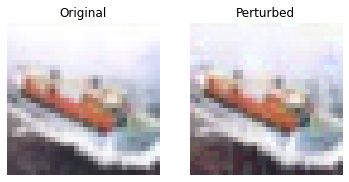

Real class: ship
Predicted class: ship with 66.0 confidence


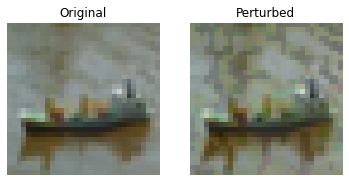

Real class: ship
Predicted class: deer with 22.0 confidence


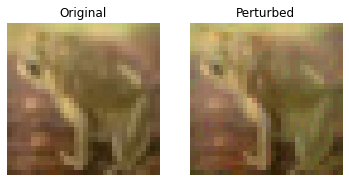

Real class: frog
Predicted class: bird with 34.0 confidence


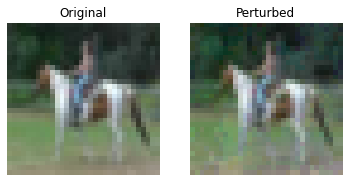

Real class: horse
Predicted class: horse with 31.0 confidence


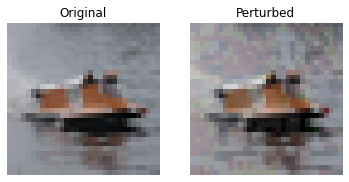

Real class: ship
Predicted class: airplane with 37.0 confidence


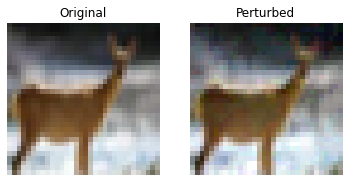

Real class: deer
Predicted class: deer with 42.0 confidence


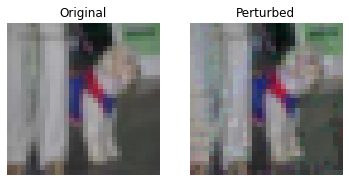

Real class: dog
Predicted class: bird with 30.0 confidence


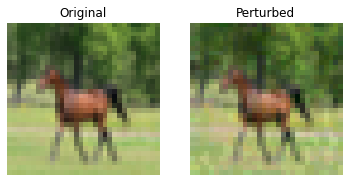

Real class: horse
Predicted class: deer with 52.0 confidence


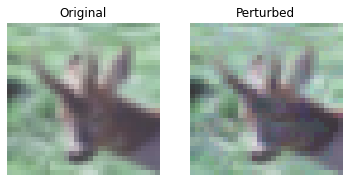

Real class: deer
Predicted class: ship with 48.0 confidence


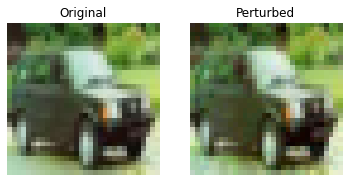

Real class: automobile
Predicted class: frog with 25.0 confidence


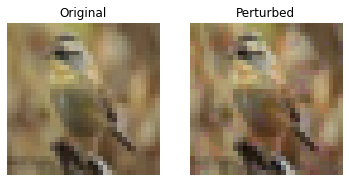

Real class: bird
Predicted class: frog with 40.0 confidence


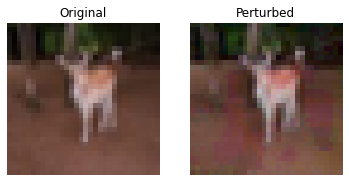

Real class: deer
Predicted class: deer with 33.0 confidence


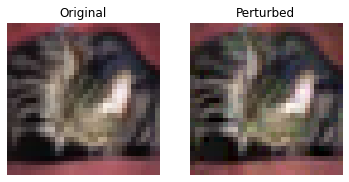

Real class: cat
Predicted class: horse with 26.0 confidence


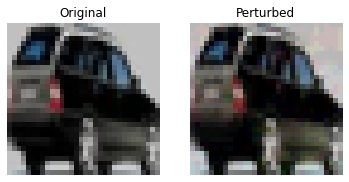

Real class: automobile
Predicted class: dog with 29.0 confidence


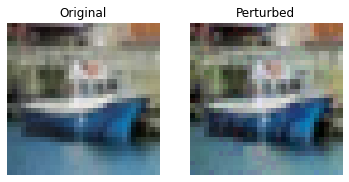

Real class: ship
Predicted class: automobile with 81.0 confidence


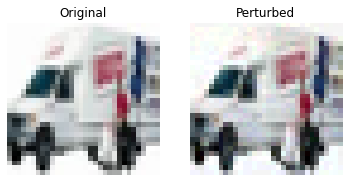

Real class: truck
Predicted class: automobile with 47.0 confidence


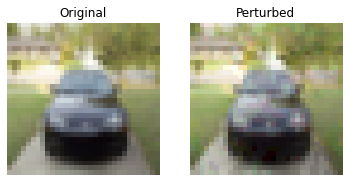

Real class: automobile
Predicted class: ship with 20.0 confidence


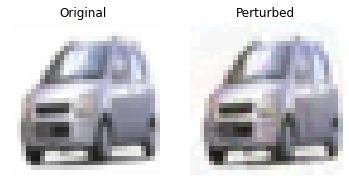

Real class: automobile
Predicted class: truck with 55.0 confidence


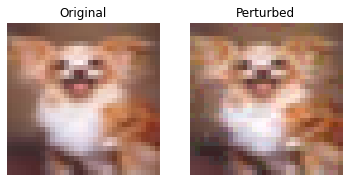

Real class: dog
Predicted class: dog with 32.0 confidence


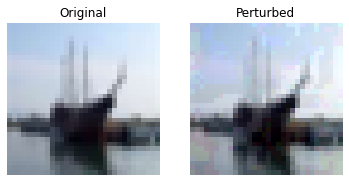

Real class: ship
Predicted class: ship with 68.0 confidence


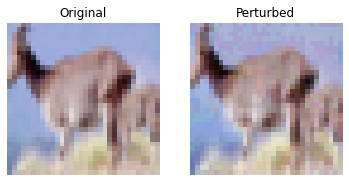

Real class: deer
Predicted class: bird with 25.0 confidence


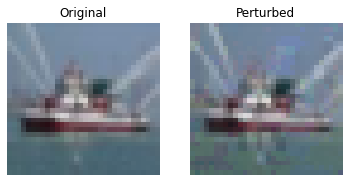

Real class: ship
Predicted class: ship with 49.0 confidence


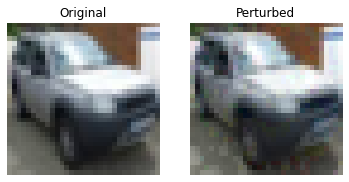

Real class: automobile
Predicted class: automobile with 35.0 confidence


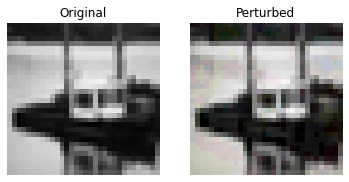

Real class: ship
Predicted class: truck with 28.0 confidence


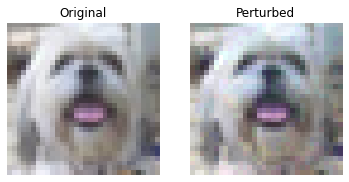

Real class: dog
Predicted class: horse with 34.0 confidence


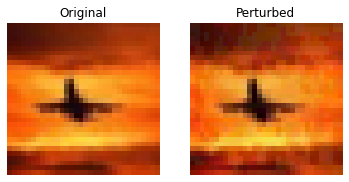

Real class: airplane
Predicted class: bird with 26.0 confidence


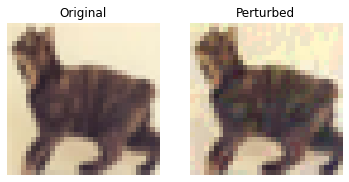

Real class: cat
Predicted class: frog with 28.0 confidence


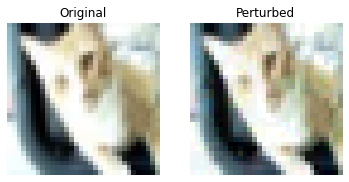

Real class: cat
Predicted class: dog with 39.0 confidence


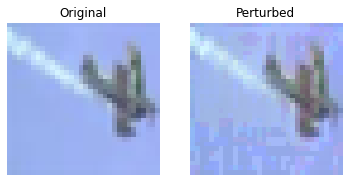

Real class: airplane
Predicted class: airplane with 67.0 confidence


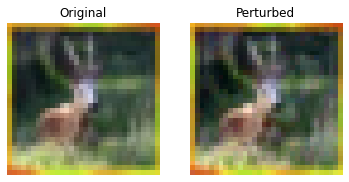

Real class: deer
Predicted class: frog with 33.0 confidence


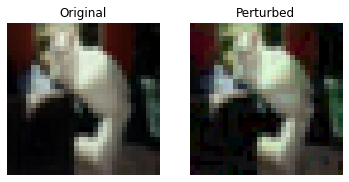

Real class: cat
Predicted class: dog with 32.0 confidence


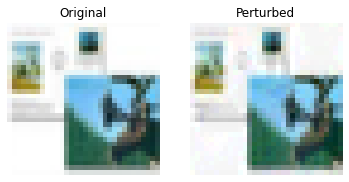

Real class: deer
Predicted class: horse with 28.0 confidence


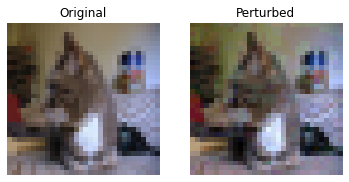

Real class: cat
Predicted class: automobile with 18.0 confidence


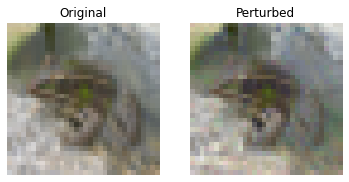

Real class: frog
Predicted class: deer with 23.0 confidence


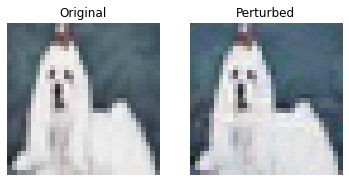

Real class: dog
Predicted class: dog with 40.0 confidence


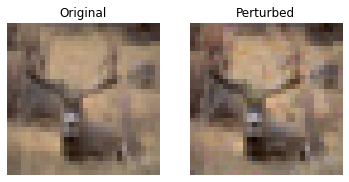

Real class: deer
Predicted class: frog with 47.0 confidence


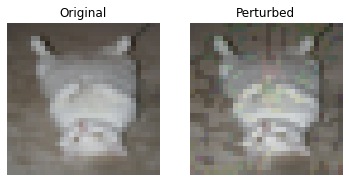

Real class: cat
Predicted class: frog with 27.0 confidence


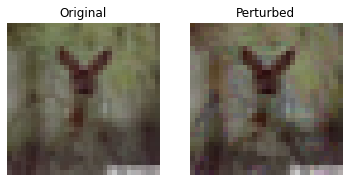

Real class: deer
Predicted class: bird with 31.0 confidence


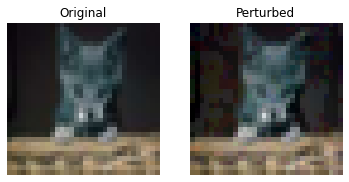

Real class: cat
Predicted class: frog with 23.0 confidence


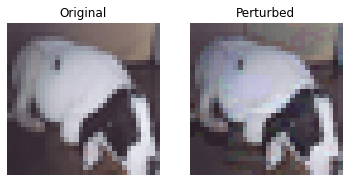

Real class: dog
Predicted class: automobile with 23.0 confidence


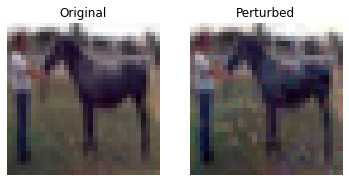

Real class: horse
Predicted class: truck with 20.0 confidence


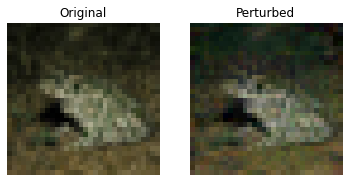

Real class: frog
Predicted class: frog with 36.0 confidence


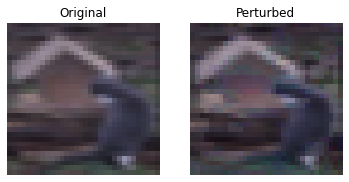

Real class: cat
Predicted class: frog with 17.0 confidence


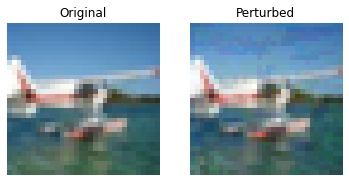

Real class: airplane
Predicted class: ship with 73.0 confidence


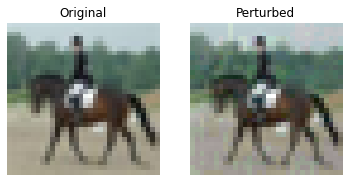

Real class: horse
Predicted class: horse with 71.0 confidence


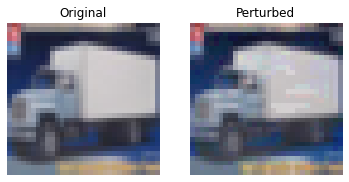

Real class: truck
Predicted class: ship with 60.0 confidence


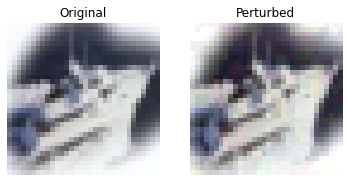

Real class: ship
Predicted class: cat with 26.0 confidence


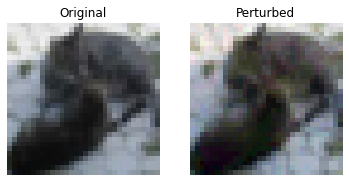

Real class: cat
Predicted class: cat with 27.0 confidence


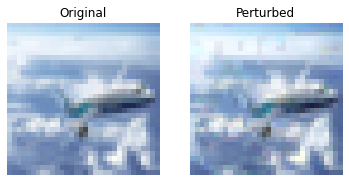

Real class: airplane
Predicted class: ship with 68.0 confidence


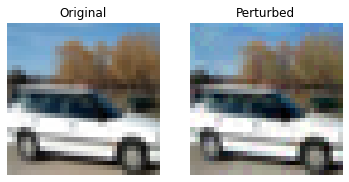

Real class: automobile
Predicted class: ship with 52.0 confidence


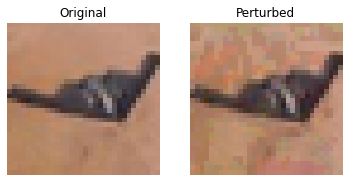

Real class: airplane
Predicted class: automobile with 18.0 confidence


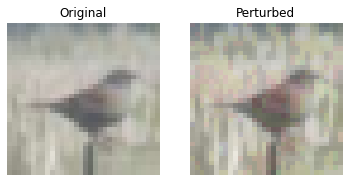

Real class: bird
Predicted class: bird with 36.0 confidence


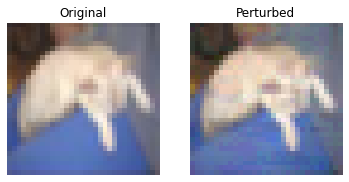

Real class: cat
Predicted class: dog with 26.0 confidence


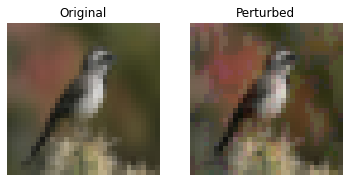

Real class: bird
Predicted class: deer with 23.0 confidence


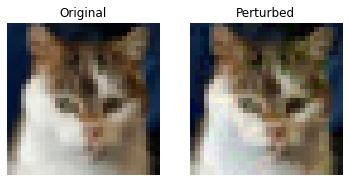

Real class: cat
Predicted class: frog with 32.0 confidence


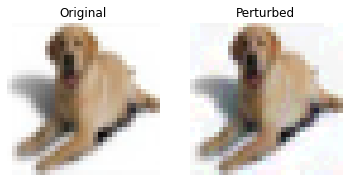

Real class: dog
Predicted class: cat with 21.0 confidence


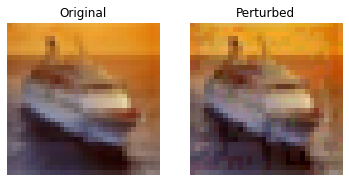

Real class: ship
Predicted class: frog with 22.0 confidence


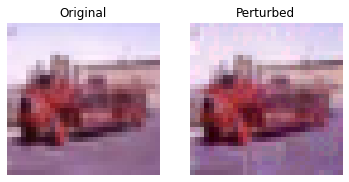

Real class: truck
Predicted class: automobile with 42.0 confidence


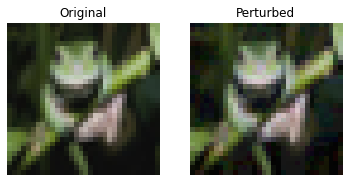

Real class: frog
Predicted class: horse with 21.0 confidence


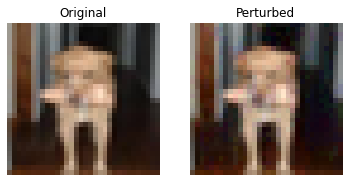

Real class: dog
Predicted class: dog with 36.0 confidence


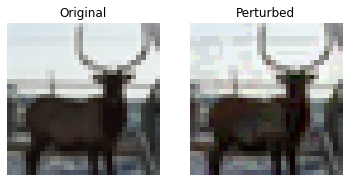

Real class: deer
Predicted class: truck with 30.0 confidence


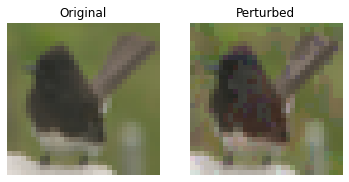

Real class: bird
Predicted class: deer with 30.0 confidence


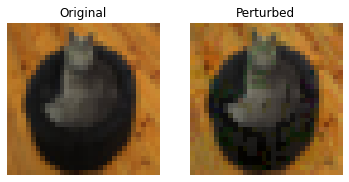

Real class: cat
Predicted class: frog with 36.0 confidence


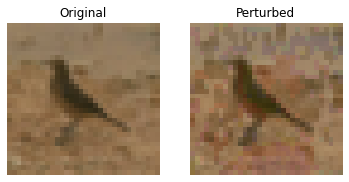

Real class: bird
Predicted class: deer with 36.0 confidence


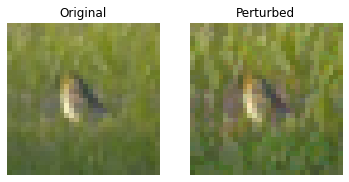

Real class: bird
Predicted class: deer with 37.0 confidence


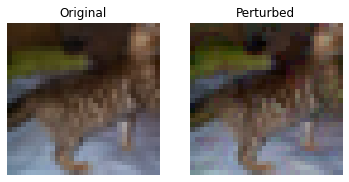

Real class: cat
Predicted class: deer with 32.0 confidence


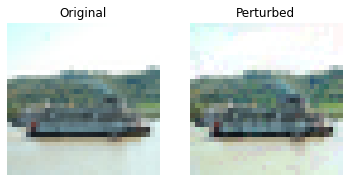

Real class: ship
Predicted class: airplane with 26.0 confidence


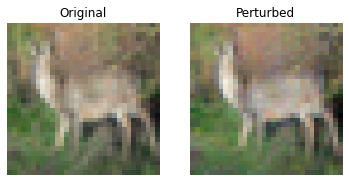

Real class: deer
Predicted class: deer with 28.0 confidence


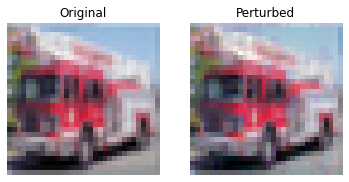

Real class: truck
Predicted class: truck with 58.0 confidence


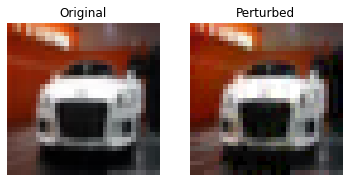

Real class: automobile
Predicted class: truck with 47.0 confidence


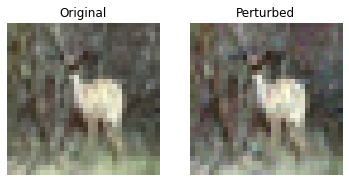

Real class: deer
Predicted class: dog with 22.0 confidence


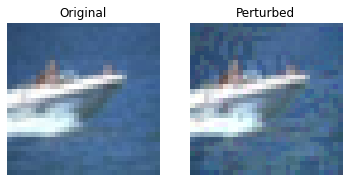

Real class: ship
Predicted class: ship with 65.0 confidence


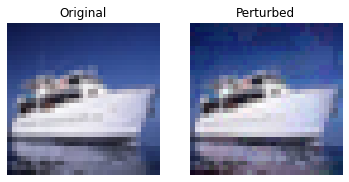

Real class: ship
Predicted class: ship with 71.0 confidence


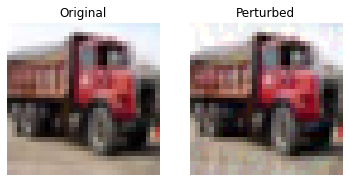

Real class: truck
Predicted class: truck with 68.0 confidence


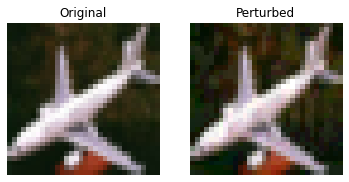

Real class: airplane
Predicted class: airplane with 24.0 confidence


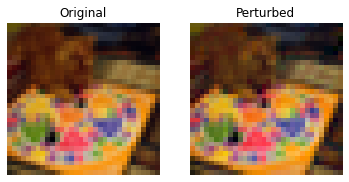

Real class: cat
Predicted class: ship with 26.0 confidence


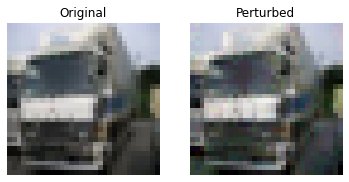

Real class: truck
Predicted class: ship with 41.0 confidence


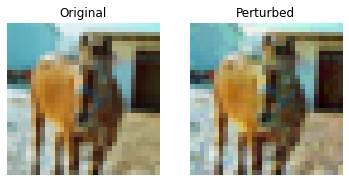

Real class: horse
Predicted class: horse with 38.0 confidence


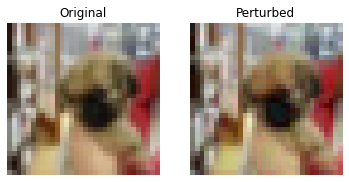

Real class: dog
Predicted class: horse with 38.0 confidence


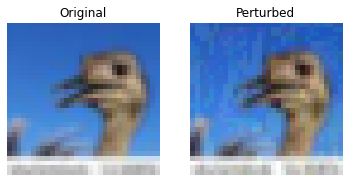

Real class: bird
Predicted class: bird with 36.0 confidence


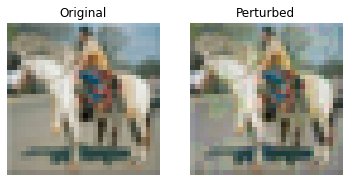

Real class: horse
Predicted class: horse with 20.0 confidence


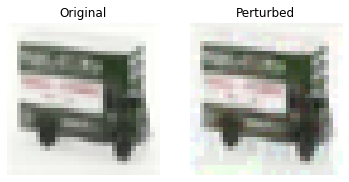

Real class: truck
Predicted class: airplane with 33.0 confidence


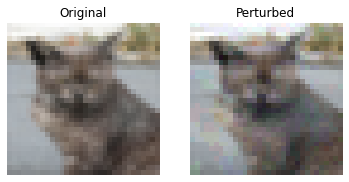

Real class: cat
Predicted class: airplane with 20.0 confidence


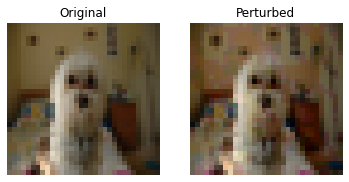

Real class: dog
Predicted class: deer with 20.0 confidence


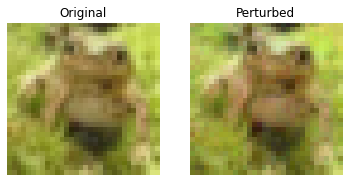

Real class: frog
Predicted class: deer with 32.0 confidence


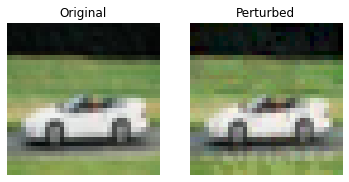

Real class: automobile
Predicted class: airplane with 35.0 confidence


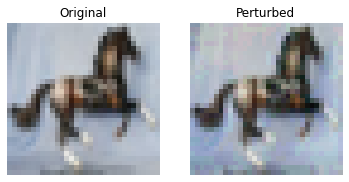

Real class: horse
Predicted class: airplane with 26.0 confidence


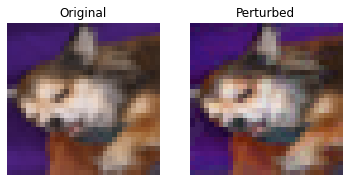

Real class: dog
Predicted class: ship with 36.0 confidence


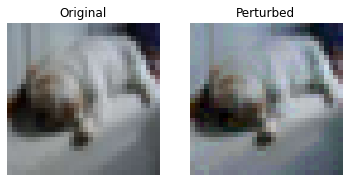

Real class: dog
Predicted class: ship with 45.0 confidence


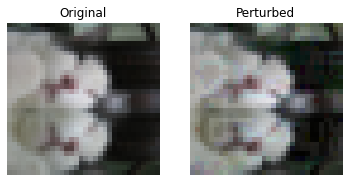

Real class: cat
Predicted class: cat with 20.0 confidence


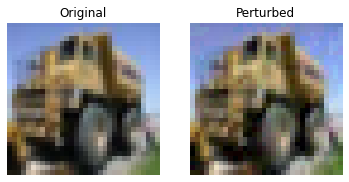

Real class: truck
Predicted class: frog with 24.0 confidence


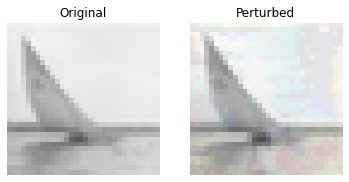

Real class: ship
Predicted class: airplane with 60.0 confidence


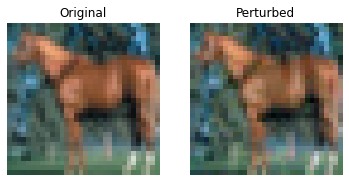

Real class: horse
Predicted class: frog with 38.0 confidence


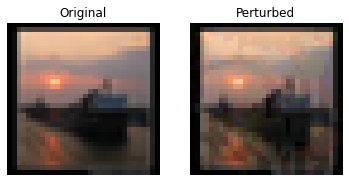

Real class: ship
Predicted class: deer with 16.0 confidence


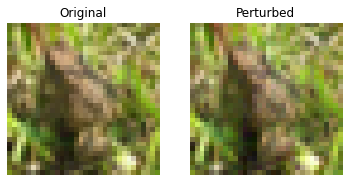

Real class: frog
Predicted class: frog with 31.0 confidence


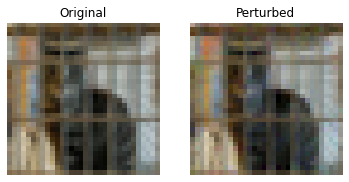

Real class: cat
Predicted class: cat with 24.0 confidence


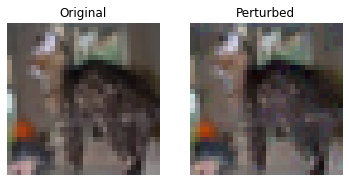

Real class: cat
Predicted class: deer with 21.0 confidence


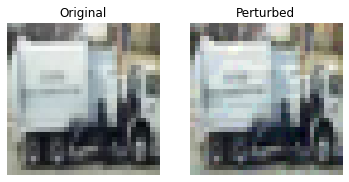

Real class: truck
Predicted class: automobile with 54.0 confidence


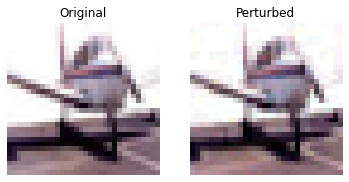

Real class: airplane
Predicted class: truck with 47.0 confidence


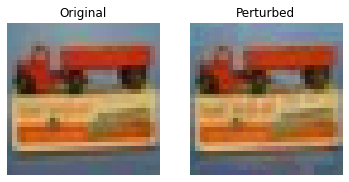

Real class: truck
Predicted class: ship with 55.0 confidence


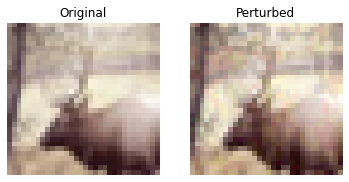

Real class: deer
Predicted class: dog with 23.0 confidence


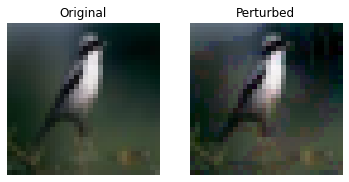

Real class: bird
Predicted class: bird with 25.0 confidence


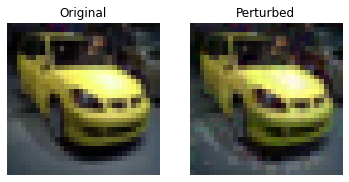

Real class: automobile
Predicted class: automobile with 52.0 confidence


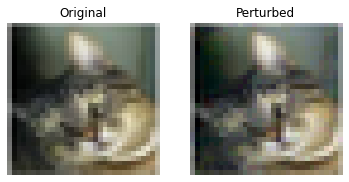

Real class: cat
Predicted class: cat with 22.0 confidence


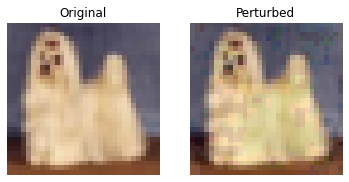

Real class: dog
Predicted class: dog with 35.0 confidence


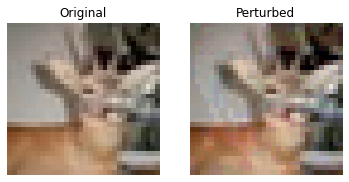

Real class: deer
Predicted class: frog with 22.0 confidence


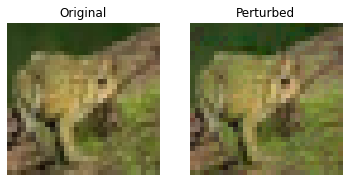

Real class: frog
Predicted class: deer with 37.0 confidence


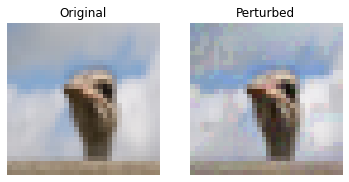

Real class: bird
Predicted class: airplane with 41.0 confidence


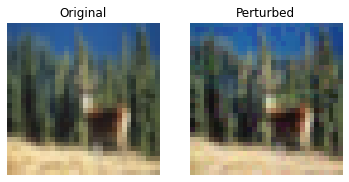

Real class: deer
Predicted class: truck with 46.0 confidence


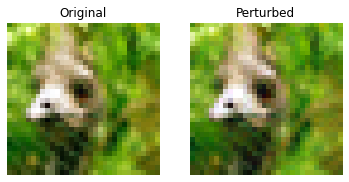

Real class: bird
Predicted class: bird with 39.0 confidence


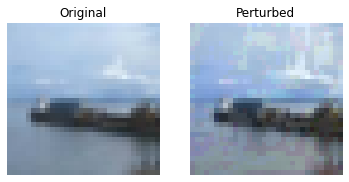

Real class: ship
Predicted class: ship with 53.0 confidence


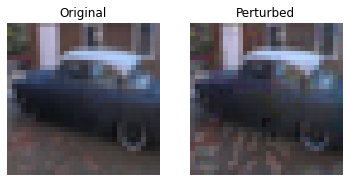

Real class: automobile
Predicted class: truck with 29.0 confidence


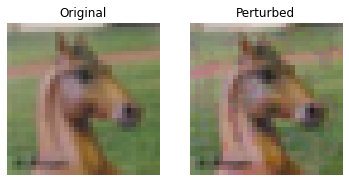

Real class: horse
Predicted class: bird with 30.0 confidence


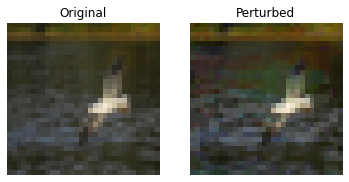

Real class: bird
Predicted class: frog with 26.0 confidence


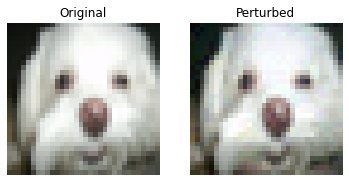

Real class: dog
Predicted class: dog with 49.0 confidence


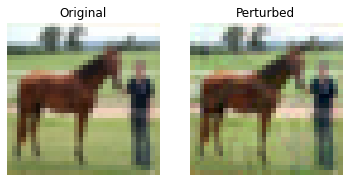

Real class: horse
Predicted class: horse with 90.0 confidence


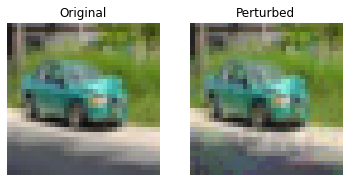

Real class: automobile
Predicted class: airplane with 28.0 confidence


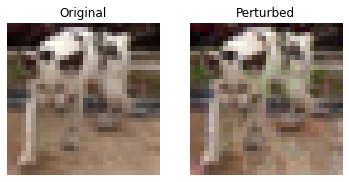

Real class: cat
Predicted class: frog with 24.0 confidence


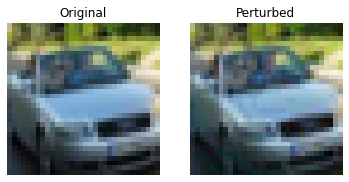

Real class: automobile
Predicted class: automobile with 60.0 confidence


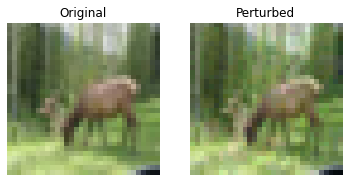

Real class: deer
Predicted class: deer with 32.0 confidence


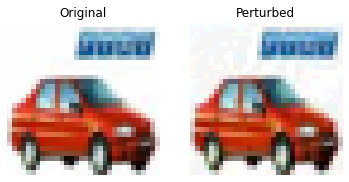

Real class: automobile
Predicted class: truck with 54.0 confidence


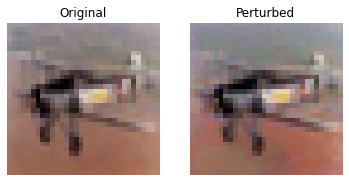

Real class: airplane
Predicted class: airplane with 49.0 confidence


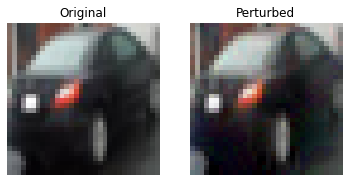

Real class: automobile
Predicted class: cat with 18.0 confidence


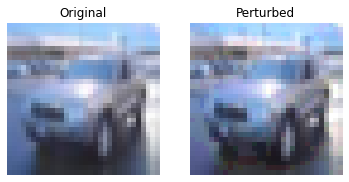

Real class: automobile
Predicted class: automobile with 62.0 confidence


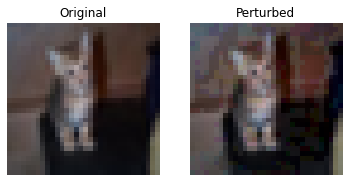

Real class: cat
Predicted class: cat with 23.0 confidence


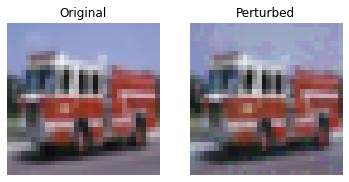

Real class: truck
Predicted class: truck with 55.0 confidence


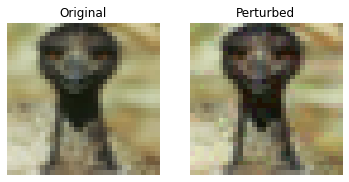

Real class: bird
Predicted class: horse with 34.0 confidence


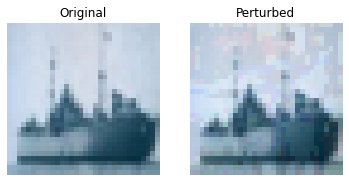

Real class: ship
Predicted class: ship with 72.0 confidence


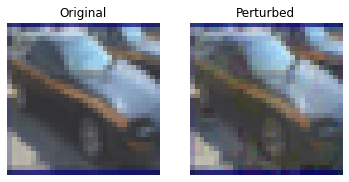

Real class: automobile
Predicted class: airplane with 18.0 confidence


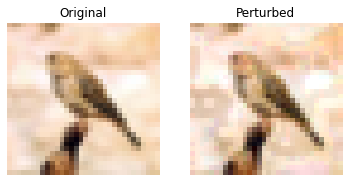

Real class: bird
Predicted class: bird with 37.0 confidence


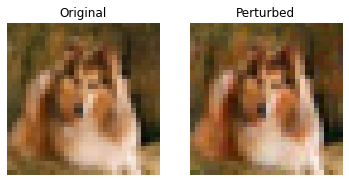

Real class: dog
Predicted class: dog with 37.0 confidence


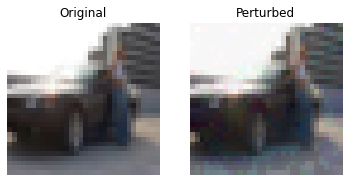

Real class: automobile
Predicted class: ship with 33.0 confidence


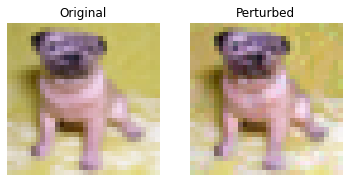

Real class: dog
Predicted class: dog with 25.0 confidence


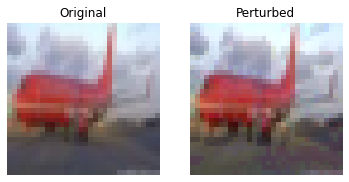

Real class: airplane
Predicted class: truck with 48.0 confidence


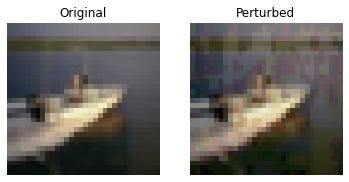

Real class: ship
Predicted class: ship with 27.0 confidence


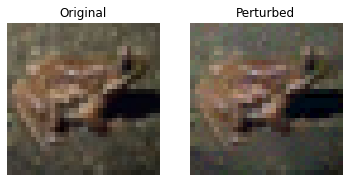

Real class: frog
Predicted class: frog with 23.0 confidence


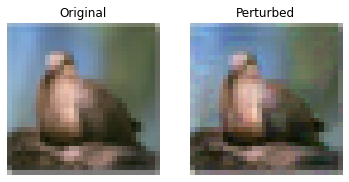

Real class: bird
Predicted class: ship with 33.0 confidence


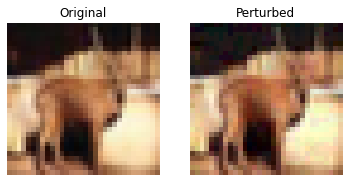

Real class: deer
Predicted class: horse with 30.0 confidence


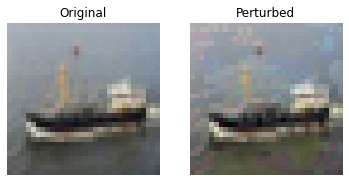

Real class: ship
Predicted class: airplane with 55.0 confidence


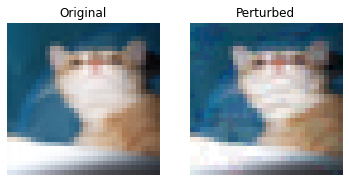

Real class: cat
Predicted class: ship with 25.0 confidence


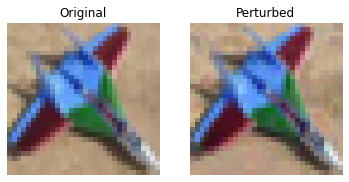

Real class: airplane
Predicted class: truck with 34.0 confidence


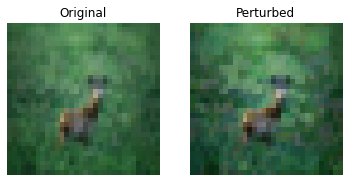

Real class: deer
Predicted class: frog with 31.0 confidence


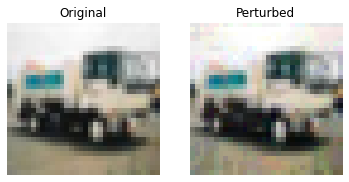

Real class: truck
Predicted class: automobile with 67.0 confidence


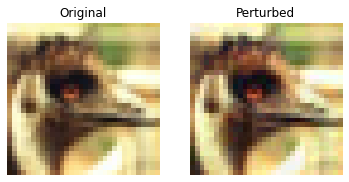

Real class: bird
Predicted class: horse with 31.0 confidence


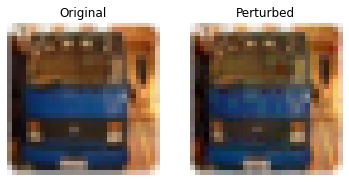

Real class: truck
Predicted class: frog with 19.0 confidence


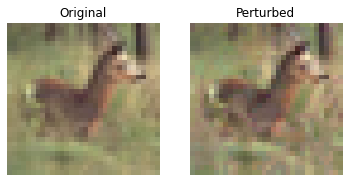

Real class: deer
Predicted class: bird with 29.0 confidence


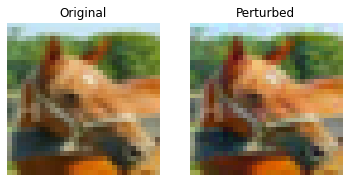

Real class: horse
Predicted class: truck with 49.0 confidence


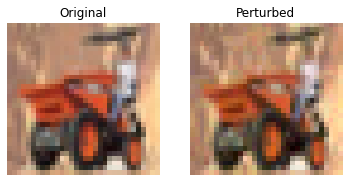

Real class: truck
Predicted class: frog with 42.0 confidence


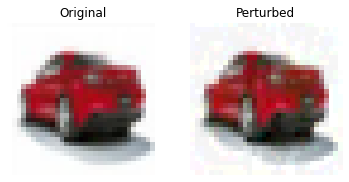

Real class: automobile
Predicted class: truck with 49.0 confidence


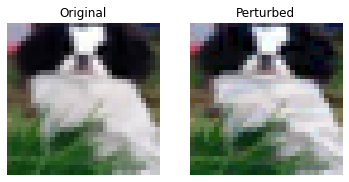

Real class: dog
Predicted class: dog with 25.0 confidence


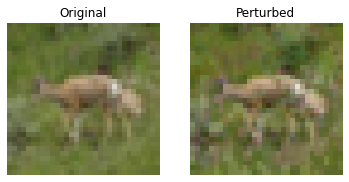

Real class: deer
Predicted class: frog with 34.0 confidence


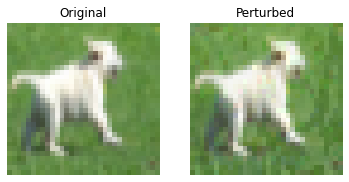

Real class: dog
Predicted class: dog with 30.0 confidence


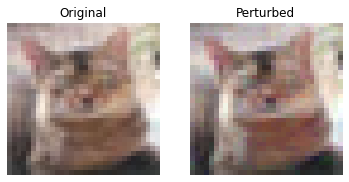

Real class: cat
Predicted class: cat with 28.0 confidence


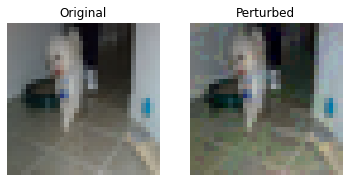

Real class: dog
Predicted class: bird with 21.0 confidence


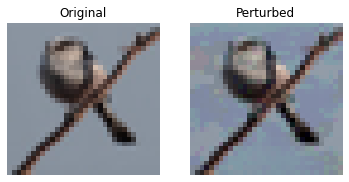

Real class: bird
Predicted class: airplane with 59.0 confidence


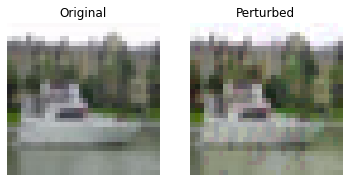

Real class: ship
Predicted class: ship with 27.0 confidence


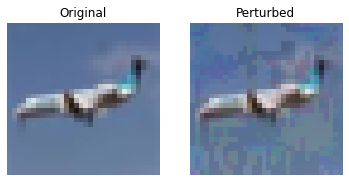

Real class: airplane
Predicted class: airplane with 74.0 confidence


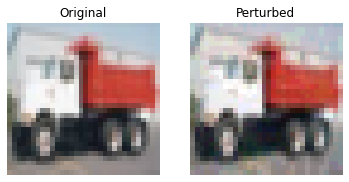

Real class: truck
Predicted class: truck with 74.0 confidence


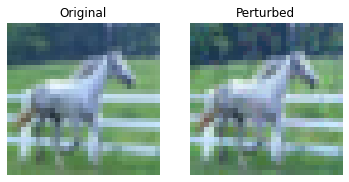

Real class: horse
Predicted class: ship with 69.0 confidence


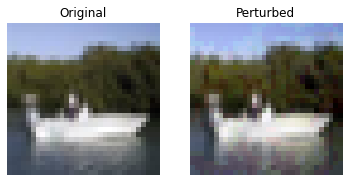

Real class: ship
Predicted class: ship with 74.0 confidence


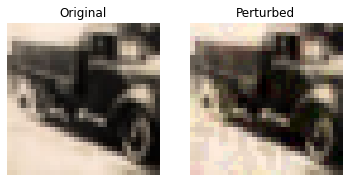

Real class: truck
Predicted class: cat with 20.0 confidence


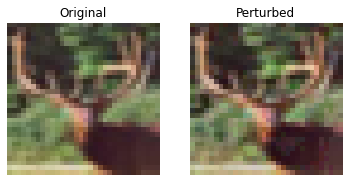

Real class: deer
Predicted class: frog with 51.0 confidence


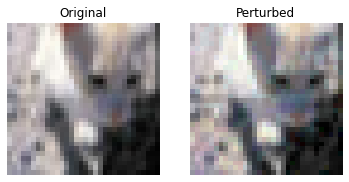

Real class: cat
Predicted class: truck with 22.0 confidence


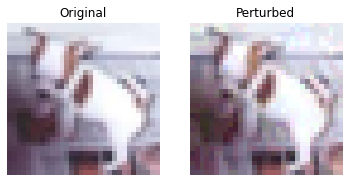

Real class: dog
Predicted class: dog with 32.0 confidence


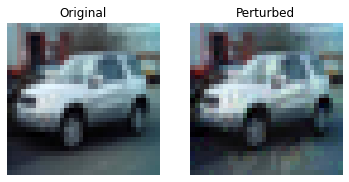

Real class: automobile
Predicted class: automobile with 53.0 confidence


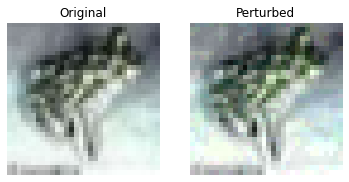

Real class: frog
Predicted class: frog with 24.0 confidence


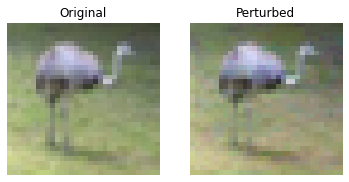

Real class: bird
Predicted class: bird with 30.0 confidence


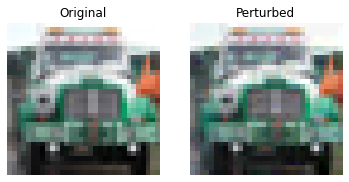

Real class: truck
Predicted class: ship with 53.0 confidence


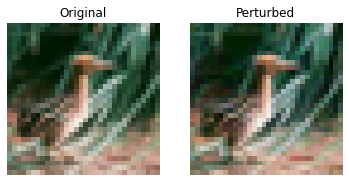

Real class: bird
Predicted class: cat with 19.0 confidence


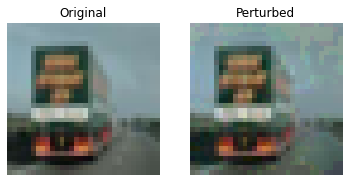

Real class: truck
Predicted class: ship with 34.0 confidence


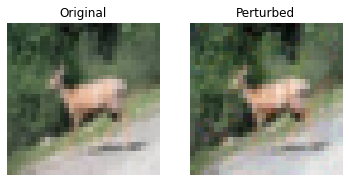

Real class: deer
Predicted class: frog with 39.0 confidence


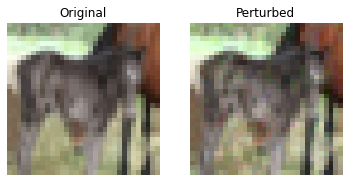

Real class: horse
Predicted class: frog with 31.0 confidence


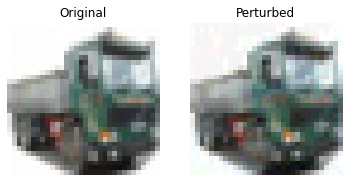

Real class: truck
Predicted class: truck with 50.0 confidence


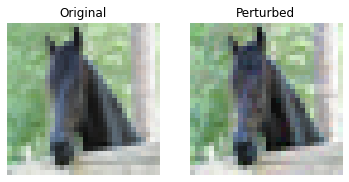

Real class: horse
Predicted class: cat with 23.0 confidence


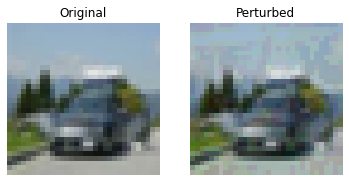

Real class: automobile
Predicted class: ship with 52.0 confidence


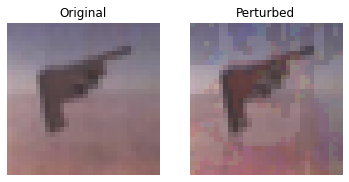

Real class: airplane
Predicted class: deer with 27.0 confidence


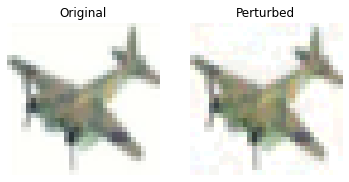

Real class: airplane
Predicted class: airplane with 48.0 confidence


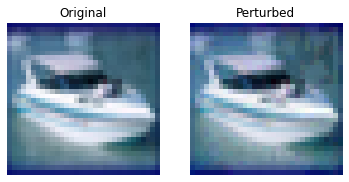

Real class: ship
Predicted class: ship with 74.0 confidence


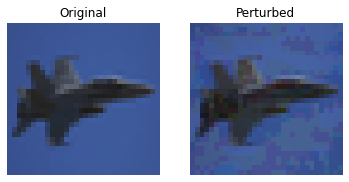

Real class: airplane
Predicted class: ship with 53.0 confidence


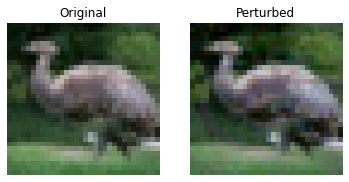

Real class: bird
Predicted class: automobile with 57.0 confidence


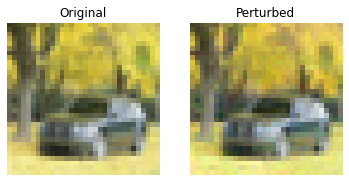

Real class: automobile
Predicted class: bird with 22.0 confidence


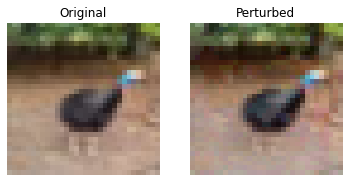

Real class: bird
Predicted class: deer with 21.0 confidence


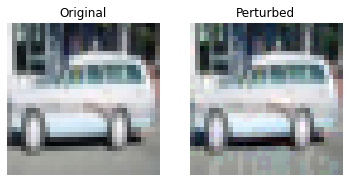

Real class: automobile
Predicted class: automobile with 74.0 confidence


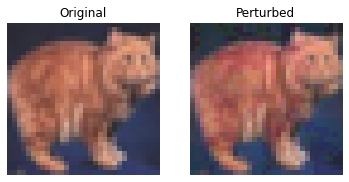

Real class: cat
Predicted class: cat with 21.0 confidence


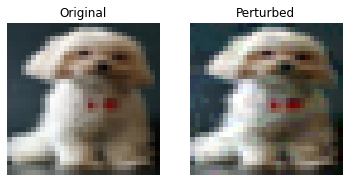

Real class: dog
Predicted class: dog with 37.0 confidence


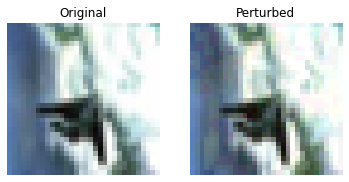

Real class: airplane
Predicted class: bird with 20.0 confidence


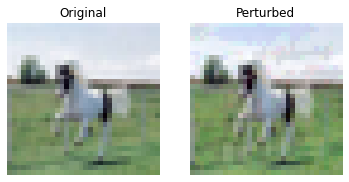

Real class: horse
Predicted class: horse with 47.0 confidence


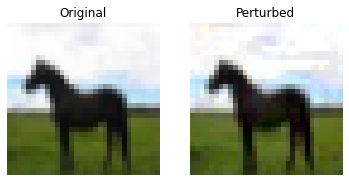

Real class: horse
Predicted class: horse with 58.0 confidence


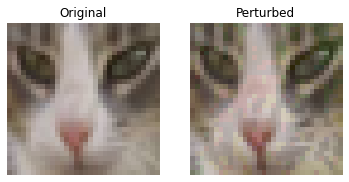

Real class: cat
Predicted class: dog with 34.0 confidence


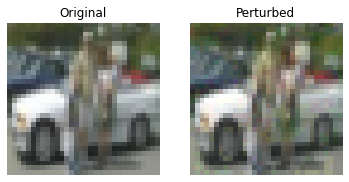

Real class: automobile
Predicted class: horse with 32.0 confidence


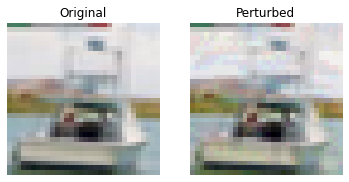

Real class: ship
Predicted class: airplane with 46.0 confidence


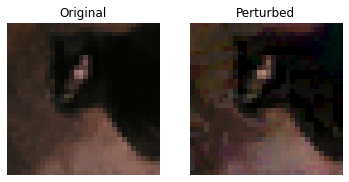

Real class: cat
Predicted class: deer with 22.0 confidence


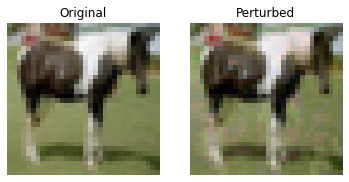

Real class: horse
Predicted class: horse with 47.0 confidence


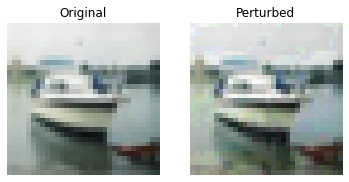

Real class: ship
Predicted class: ship with 64.0 confidence


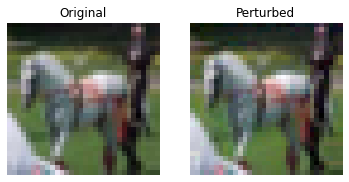

Real class: horse
Predicted class: horse with 54.0 confidence


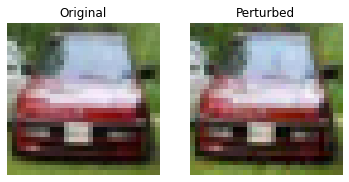

Real class: automobile
Predicted class: truck with 62.0 confidence


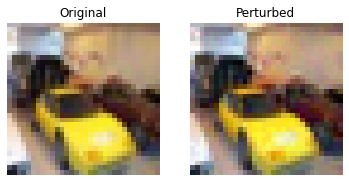

Real class: automobile
Predicted class: automobile with 32.0 confidence


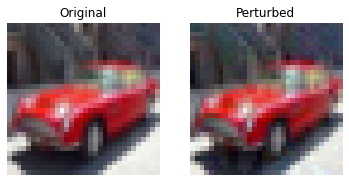

Real class: automobile
Predicted class: automobile with 77.0 confidence


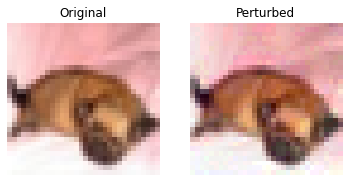

Real class: dog
Predicted class: automobile with 27.0 confidence


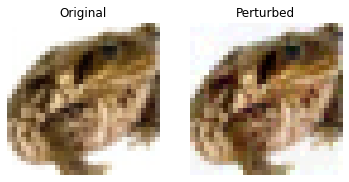

Real class: frog
Predicted class: frog with 25.0 confidence


Robust KAF CNN original Accuracy 0.605%
Robust KAF CNN Accuracy0.36%
time: 4min 12s


In [ ]:
# Robustness Accuracy on train set for rob_kaf_cnn model, set plot=True if you want image-wise stats
nfool = 0
nacc = 0
for perturbed_img in rob_kaf_train_adv:
    
    original_idx = find_original_img(perturbed_img, set='train')
    nacc += attack_succeed(x_train[original_idx], original_idx, x_train[original_idx], rob_kaf_cnn, plot=False,set='train') 
    nfool += attack_succeed(x_train[original_idx], original_idx, perturbed_img, rob_kaf_cnn, plot=True, set='train') 

print("\n\nRobust KAF CNN original Accuracy {}%\nRobust KAF CNN Accuracy{}%".format(nacc/200, nfool/200))

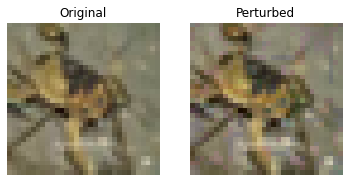

Real class: frog
Predicted class: frog with 43.0 confidence


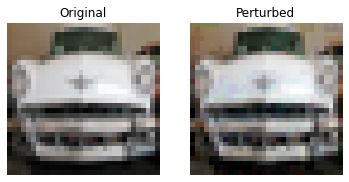

Real class: automobile
Predicted class: automobile with 61.0 confidence


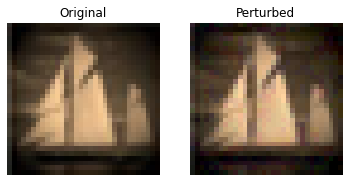

Real class: ship
Predicted class: cat with 29.0 confidence


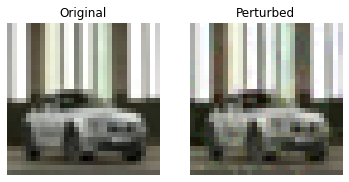

Real class: automobile
Predicted class: truck with 49.0 confidence


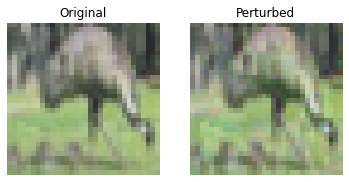

Real class: bird
Predicted class: deer with 34.0 confidence


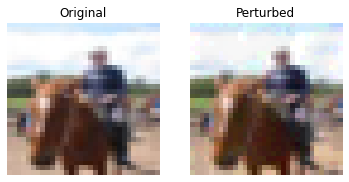

Real class: horse
Predicted class: horse with 23.0 confidence


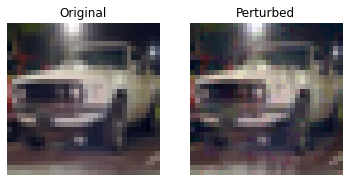

Real class: automobile
Predicted class: automobile with 30.0 confidence


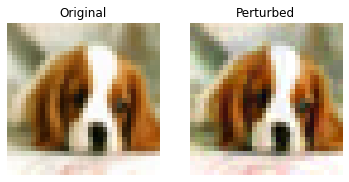

Real class: dog
Predicted class: dog with 23.0 confidence


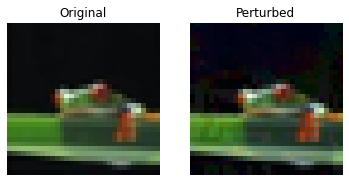

Real class: frog
Predicted class: airplane with 32.0 confidence


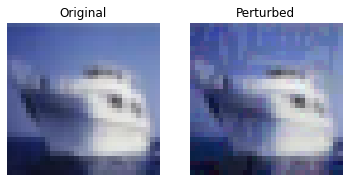

Real class: ship
Predicted class: ship with 57.0 confidence


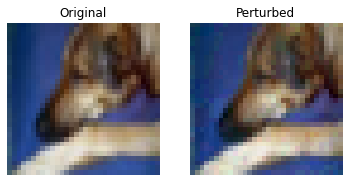

Real class: dog
Predicted class: ship with 53.0 confidence


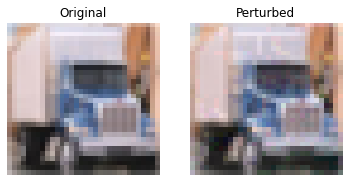

Real class: truck
Predicted class: ship with 53.0 confidence


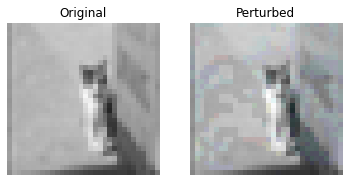

Real class: cat
Predicted class: ship with 40.0 confidence


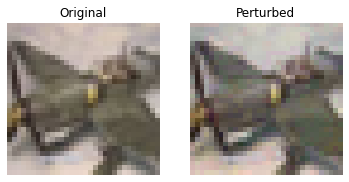

Real class: airplane
Predicted class: truck with 21.0 confidence


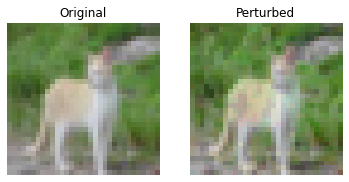

Real class: cat
Predicted class: frog with 28.0 confidence


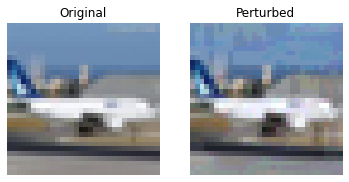

Real class: airplane
Predicted class: automobile with 35.0 confidence


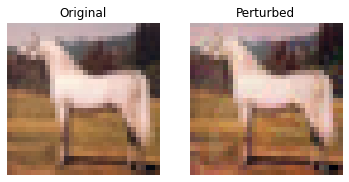

Real class: horse
Predicted class: horse with 29.0 confidence


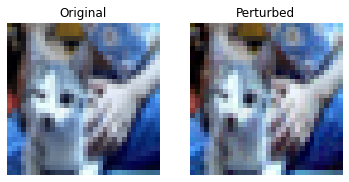

Real class: cat
Predicted class: dog with 32.0 confidence


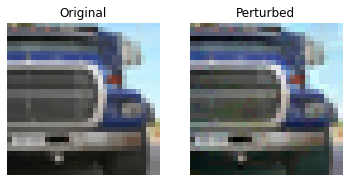

Real class: truck
Predicted class: ship with 39.0 confidence


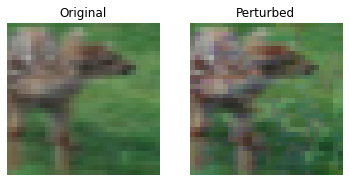

Real class: deer
Predicted class: bird with 32.0 confidence


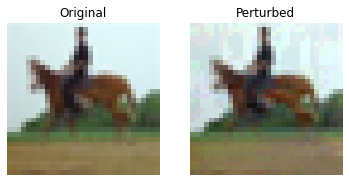

Real class: horse
Predicted class: airplane with 37.0 confidence


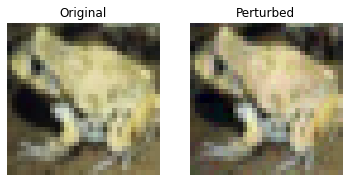

Real class: frog
Predicted class: frog with 33.0 confidence


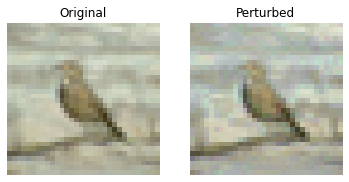

Real class: bird
Predicted class: airplane with 42.0 confidence


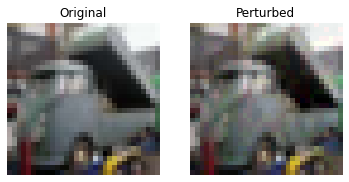

Real class: truck
Predicted class: frog with 20.0 confidence


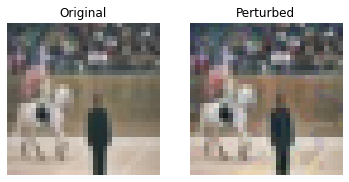

Real class: horse
Predicted class: horse with 52.0 confidence


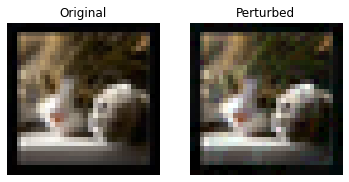

Real class: cat
Predicted class: ship with 25.0 confidence


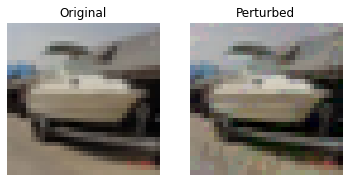

Real class: ship
Predicted class: ship with 44.0 confidence


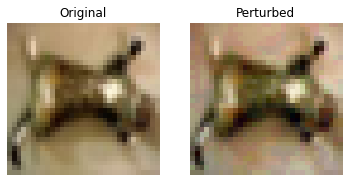

Real class: cat
Predicted class: frog with 34.0 confidence


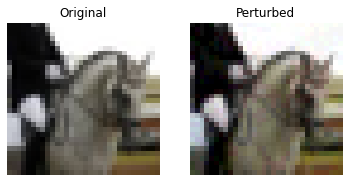

Real class: horse
Predicted class: horse with 46.0 confidence


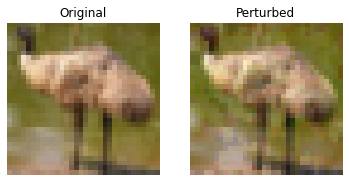

Real class: bird
Predicted class: frog with 33.0 confidence


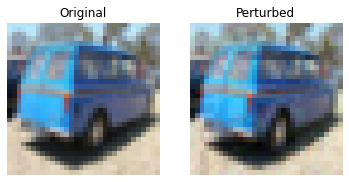

Real class: automobile
Predicted class: automobile with 69.0 confidence


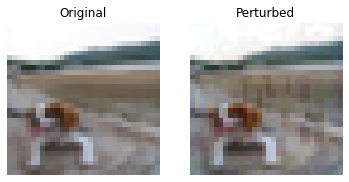

Real class: dog
Predicted class: ship with 42.0 confidence


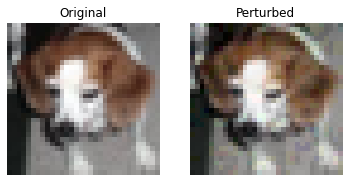

Real class: dog
Predicted class: frog with 31.0 confidence


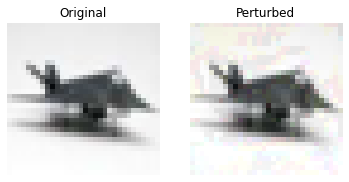

Real class: airplane
Predicted class: airplane with 66.0 confidence


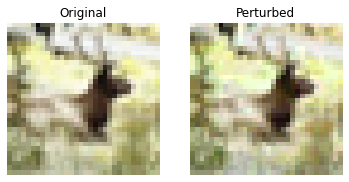

Real class: deer
Predicted class: bird with 23.0 confidence


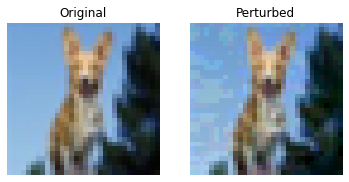

Real class: dog
Predicted class: bird with 24.0 confidence


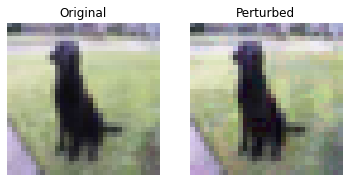

Real class: dog
Predicted class: bird with 29.0 confidence


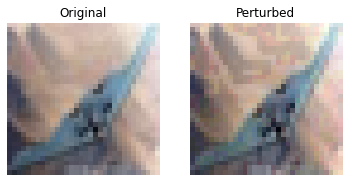

Real class: airplane
Predicted class: bird with 24.0 confidence


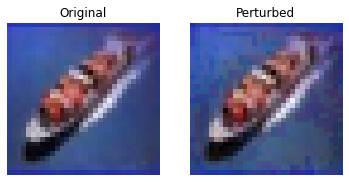

Real class: ship
Predicted class: ship with 63.0 confidence


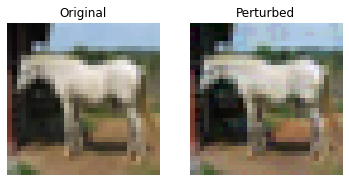

Real class: horse
Predicted class: truck with 34.0 confidence


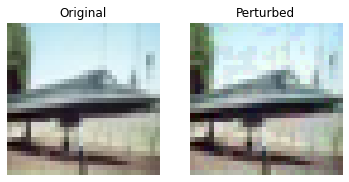

Real class: airplane
Predicted class: airplane with 45.0 confidence


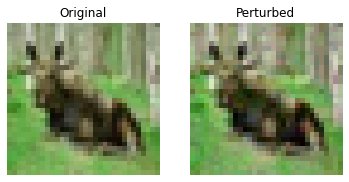

Real class: deer
Predicted class: frog with 44.0 confidence


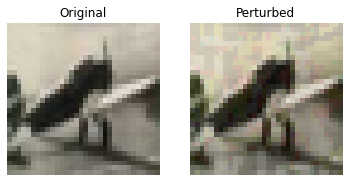

Real class: airplane
Predicted class: bird with 26.0 confidence


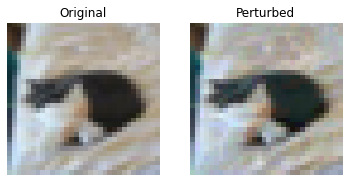

Real class: cat
Predicted class: airplane with 21.0 confidence


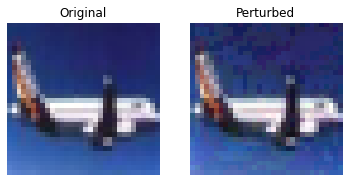

Real class: airplane
Predicted class: airplane with 52.0 confidence


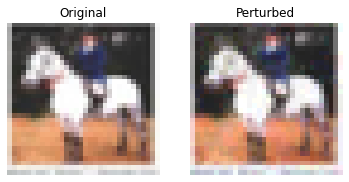

Real class: horse
Predicted class: horse with 36.0 confidence


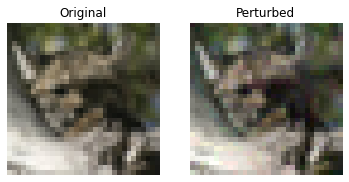

Real class: cat
Predicted class: deer with 23.0 confidence


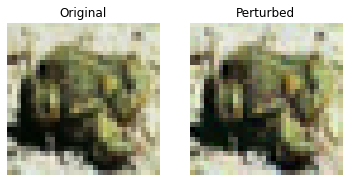

Real class: frog
Predicted class: frog with 28.0 confidence


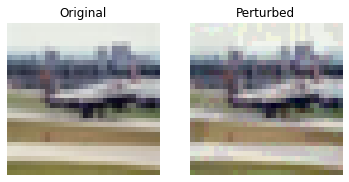

Real class: airplane
Predicted class: airplane with 65.0 confidence


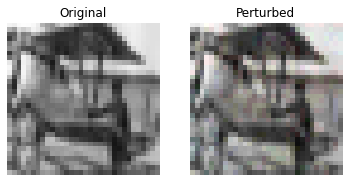

Real class: airplane
Predicted class: horse with 27.0 confidence


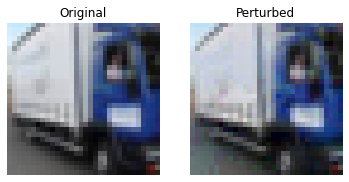

Real class: truck
Predicted class: truck with 36.0 confidence


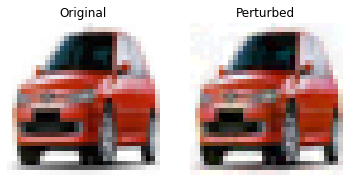

Real class: automobile
Predicted class: truck with 61.0 confidence


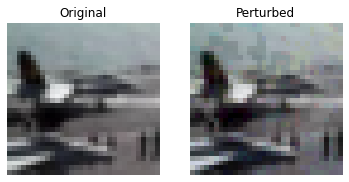

Real class: airplane
Predicted class: ship with 66.0 confidence


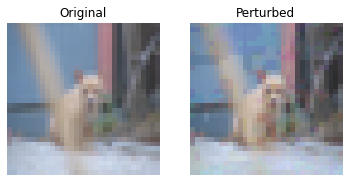

Real class: dog
Predicted class: cat with 22.0 confidence


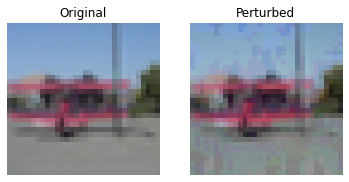

Real class: airplane
Predicted class: ship with 70.0 confidence


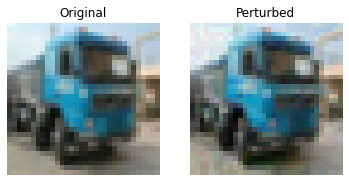

Real class: truck
Predicted class: automobile with 53.0 confidence


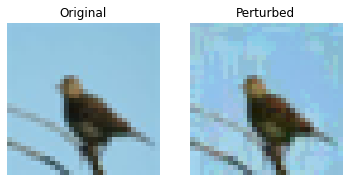

Real class: bird
Predicted class: bird with 40.0 confidence


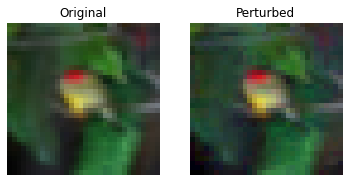

Real class: bird
Predicted class: bird with 30.0 confidence


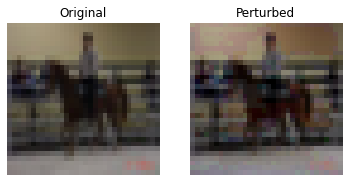

Real class: horse
Predicted class: truck with 30.0 confidence


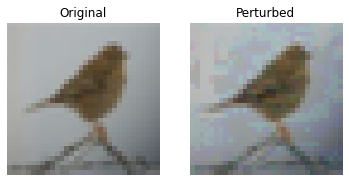

Real class: bird
Predicted class: airplane with 38.0 confidence


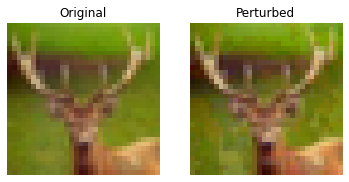

Real class: deer
Predicted class: frog with 49.0 confidence


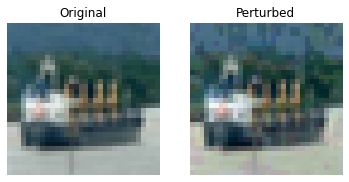

Real class: ship
Predicted class: automobile with 45.0 confidence


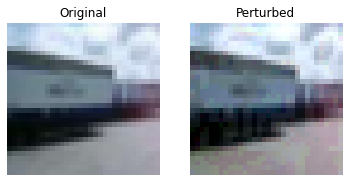

Real class: truck
Predicted class: ship with 40.0 confidence


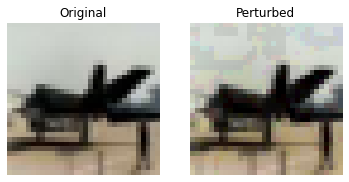

Real class: airplane
Predicted class: horse with 50.0 confidence


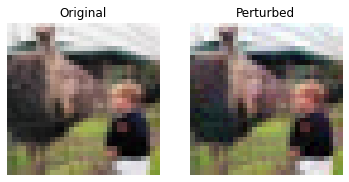

Real class: bird
Predicted class: horse with 46.0 confidence


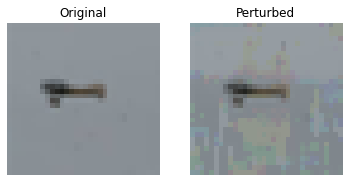

Real class: airplane
Predicted class: airplane with 49.0 confidence


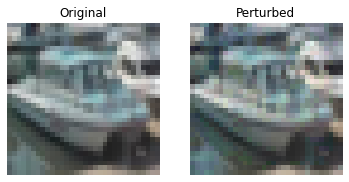

Real class: ship
Predicted class: ship with 71.0 confidence


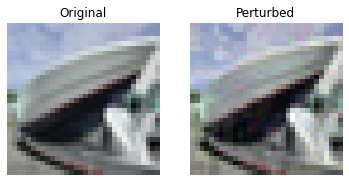

Real class: ship
Predicted class: airplane with 44.0 confidence


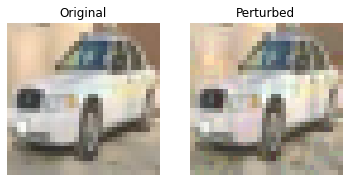

Real class: automobile
Predicted class: automobile with 56.0 confidence


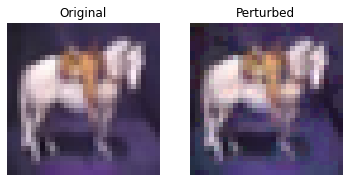

Real class: horse
Predicted class: dog with 18.0 confidence


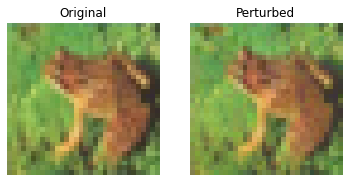

Real class: frog
Predicted class: deer with 36.0 confidence


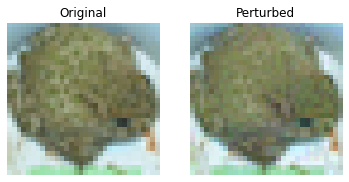

Real class: frog
Predicted class: frog with 33.0 confidence


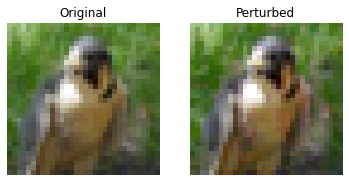

Real class: bird
Predicted class: horse with 19.0 confidence


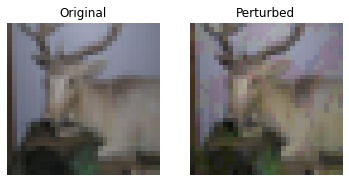

Real class: deer
Predicted class: frog with 23.0 confidence


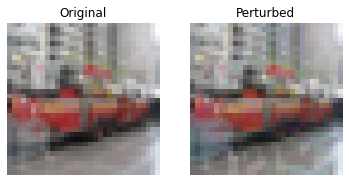

Real class: truck
Predicted class: ship with 55.0 confidence


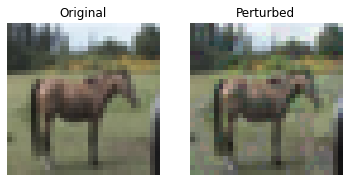

Real class: horse
Predicted class: horse with 50.0 confidence


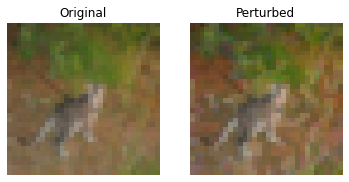

Real class: cat
Predicted class: frog with 35.0 confidence


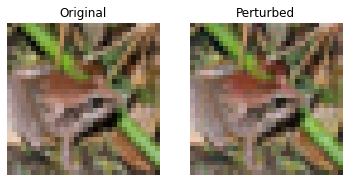

Real class: frog
Predicted class: frog with 41.0 confidence


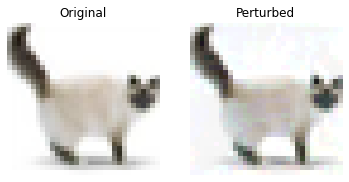

Real class: cat
Predicted class: airplane with 33.0 confidence


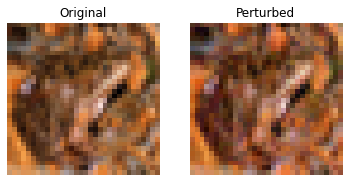

Real class: frog
Predicted class: frog with 47.0 confidence


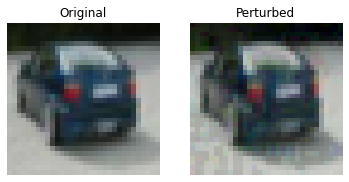

Real class: automobile
Predicted class: automobile with 22.0 confidence


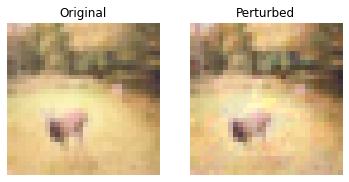

Real class: deer
Predicted class: cat with 24.0 confidence


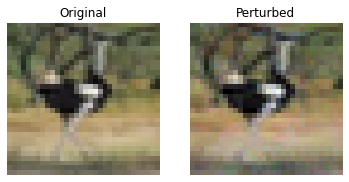

Real class: bird
Predicted class: deer with 26.0 confidence


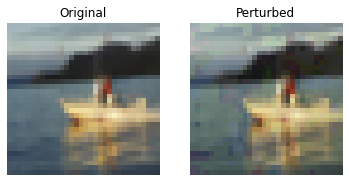

Real class: ship
Predicted class: ship with 41.0 confidence


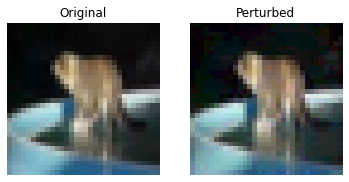

Real class: cat
Predicted class: horse with 25.0 confidence


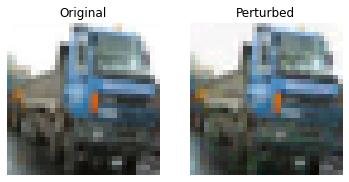

Real class: truck
Predicted class: ship with 39.0 confidence


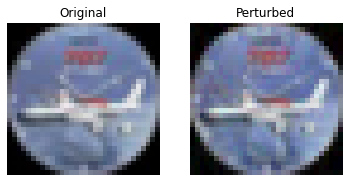

Real class: airplane
Predicted class: ship with 46.0 confidence


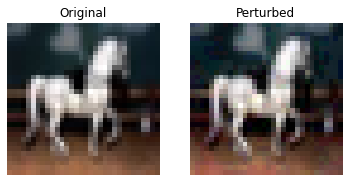

Real class: horse
Predicted class: horse with 58.0 confidence


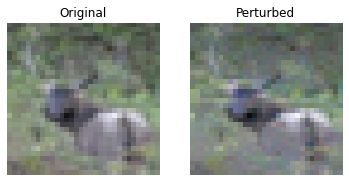

Real class: deer
Predicted class: airplane with 39.0 confidence


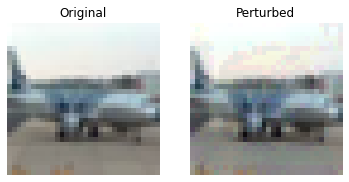

Real class: airplane
Predicted class: ship with 29.0 confidence


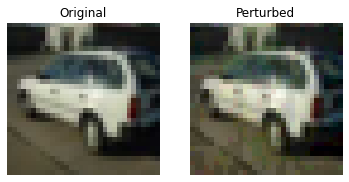

Real class: automobile
Predicted class: automobile with 48.0 confidence


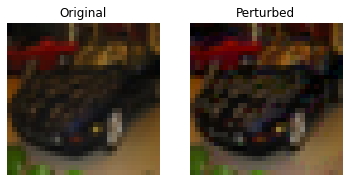

Real class: automobile
Predicted class: frog with 27.0 confidence


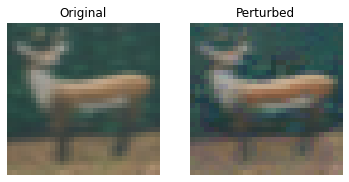

Real class: deer
Predicted class: airplane with 49.0 confidence


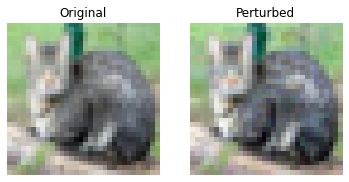

Real class: cat
Predicted class: truck with 23.0 confidence


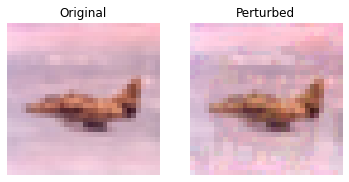

Real class: airplane
Predicted class: airplane with 57.0 confidence


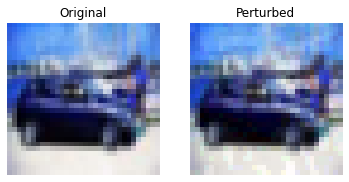

Real class: automobile
Predicted class: truck with 38.0 confidence


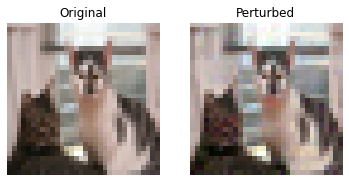

Real class: cat
Predicted class: truck with 24.0 confidence


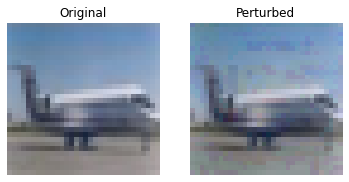

Real class: airplane
Predicted class: ship with 61.0 confidence


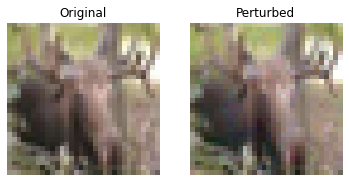

Real class: deer
Predicted class: deer with 25.0 confidence


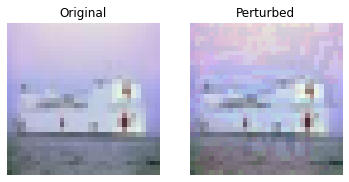

Real class: ship
Predicted class: ship with 64.0 confidence


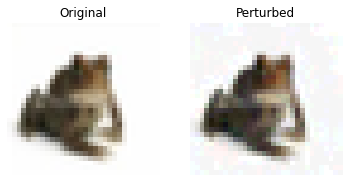

Real class: frog
Predicted class: frog with 22.0 confidence


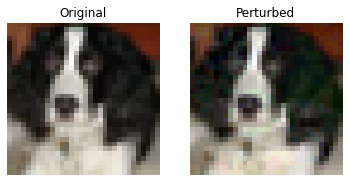

Real class: dog
Predicted class: dog with 41.0 confidence


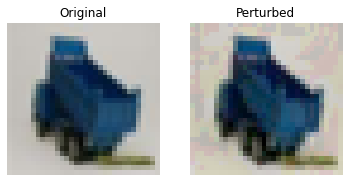

Real class: truck
Predicted class: truck with 25.0 confidence


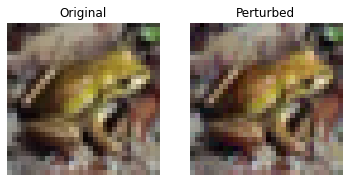

Real class: frog
Predicted class: frog with 59.0 confidence


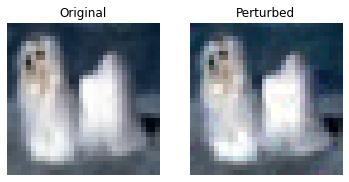

Real class: dog
Predicted class: dog with 45.0 confidence


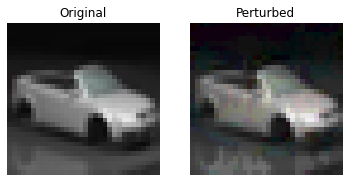

Real class: automobile
Predicted class: automobile with 38.0 confidence


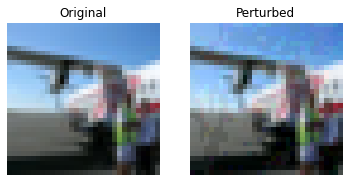

Real class: airplane
Predicted class: truck with 37.0 confidence


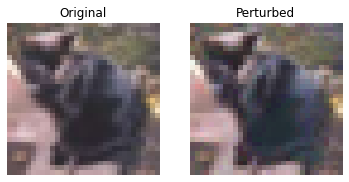

Real class: cat
Predicted class: bird with 24.0 confidence


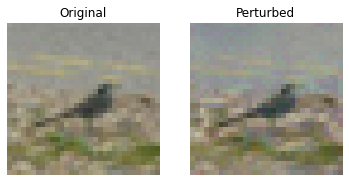

Real class: bird
Predicted class: airplane with 54.0 confidence


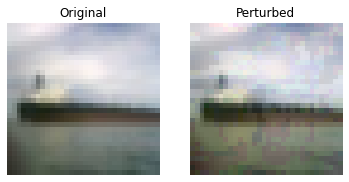

Real class: ship
Predicted class: ship with 55.0 confidence


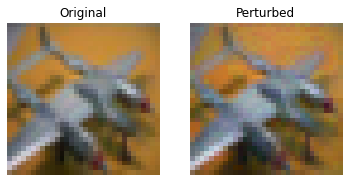

Real class: airplane
Predicted class: airplane with 23.0 confidence


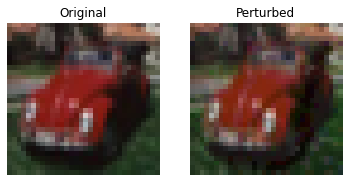

Real class: automobile
Predicted class: frog with 23.0 confidence


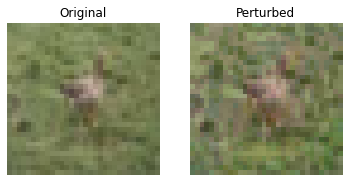

Real class: bird
Predicted class: deer with 39.0 confidence


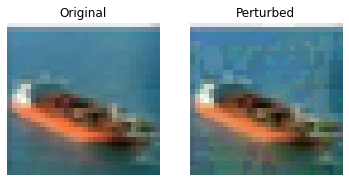

Real class: ship
Predicted class: ship with 62.0 confidence


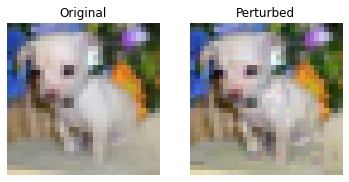

Real class: dog
Predicted class: dog with 33.0 confidence


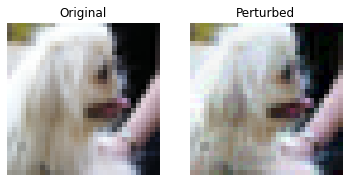

Real class: dog
Predicted class: cat with 27.0 confidence


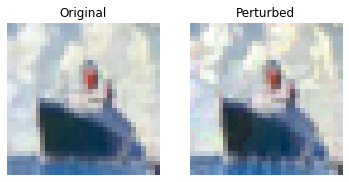

Real class: ship
Predicted class: ship with 68.0 confidence


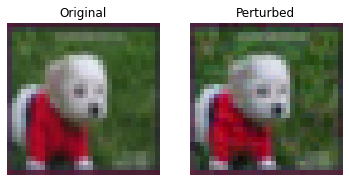

Real class: dog
Predicted class: automobile with 33.0 confidence


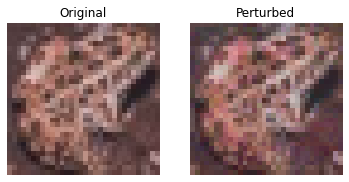

Real class: frog
Predicted class: frog with 47.0 confidence


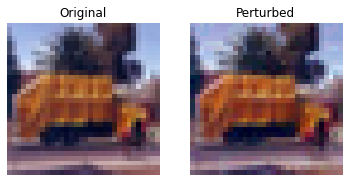

Real class: truck
Predicted class: automobile with 64.0 confidence


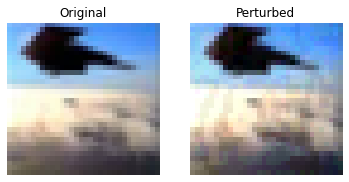

Real class: airplane
Predicted class: ship with 58.0 confidence


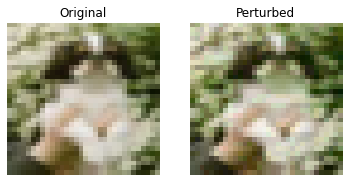

Real class: dog
Predicted class: frog with 34.0 confidence


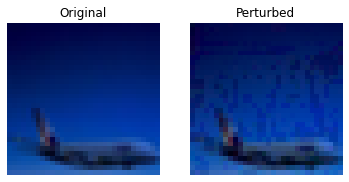

Real class: airplane
Predicted class: ship with 56.0 confidence


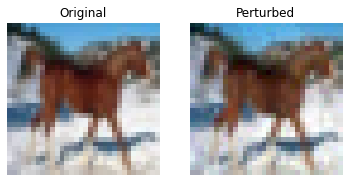

Real class: horse
Predicted class: horse with 60.0 confidence


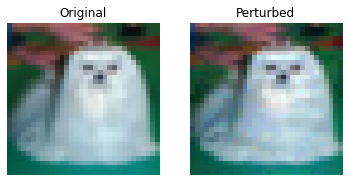

Real class: dog
Predicted class: dog with 44.0 confidence


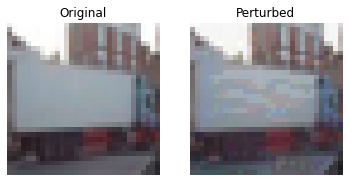

Real class: truck
Predicted class: ship with 52.0 confidence


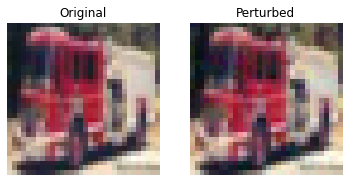

Real class: truck
Predicted class: truck with 49.0 confidence


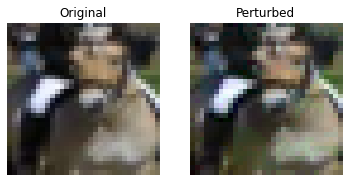

Real class: horse
Predicted class: deer with 17.0 confidence


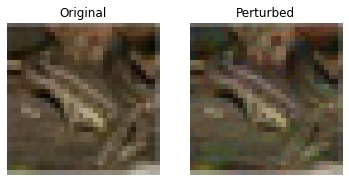

Real class: frog
Predicted class: frog with 32.0 confidence


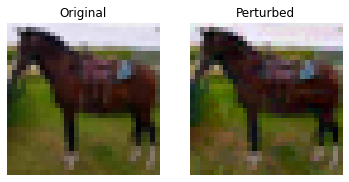

Real class: horse
Predicted class: horse with 36.0 confidence


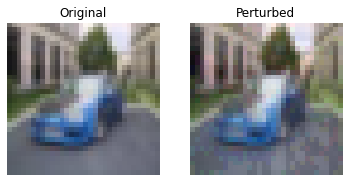

Real class: automobile
Predicted class: dog with 23.0 confidence


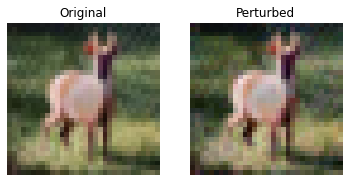

Real class: deer
Predicted class: dog with 19.0 confidence


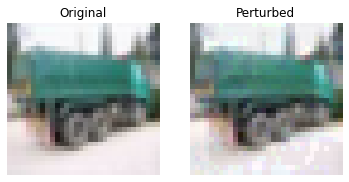

Real class: truck
Predicted class: airplane with 38.0 confidence


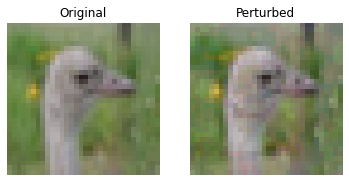

Real class: bird
Predicted class: bird with 24.0 confidence


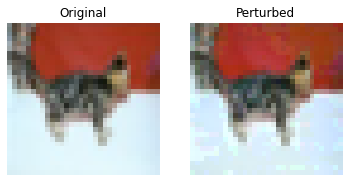

Real class: cat
Predicted class: horse with 23.0 confidence


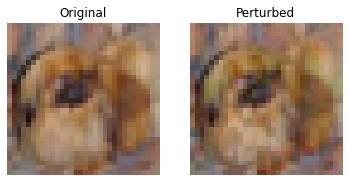

Real class: dog
Predicted class: frog with 34.0 confidence


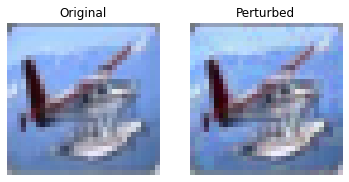

Real class: airplane
Predicted class: airplane with 48.0 confidence


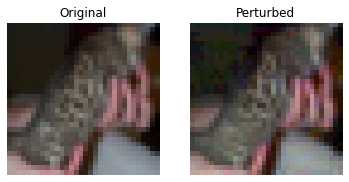

Real class: cat
Predicted class: deer with 37.0 confidence


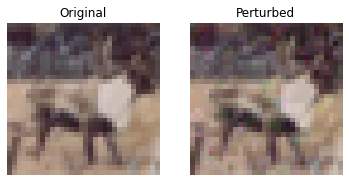

Real class: deer
Predicted class: deer with 36.0 confidence


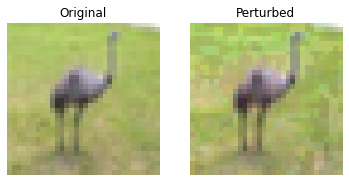

Real class: bird
Predicted class: deer with 40.0 confidence


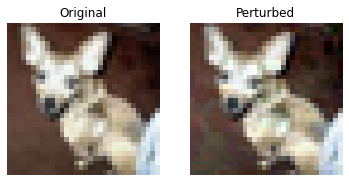

Real class: dog
Predicted class: dog with 33.0 confidence


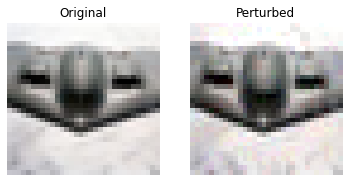

Real class: airplane
Predicted class: truck with 55.0 confidence


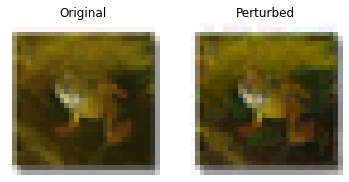

Real class: frog
Predicted class: truck with 28.0 confidence


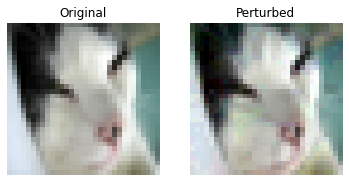

Real class: cat
Predicted class: dog with 47.0 confidence


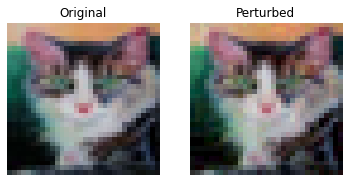

Real class: cat
Predicted class: dog with 37.0 confidence


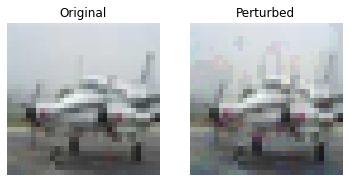

Real class: airplane
Predicted class: ship with 71.0 confidence


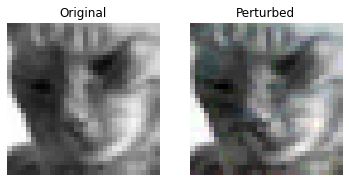

Real class: cat
Predicted class: cat with 28.0 confidence


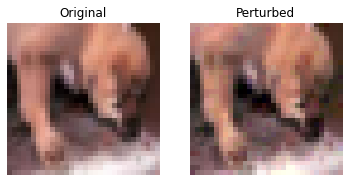

Real class: dog
Predicted class: cat with 24.0 confidence


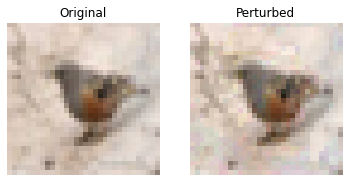

Real class: bird
Predicted class: bird with 25.0 confidence


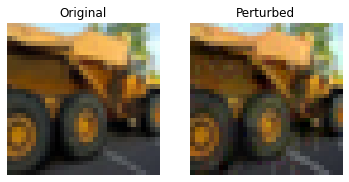

Real class: truck
Predicted class: frog with 37.0 confidence


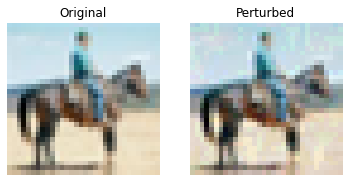

Real class: horse
Predicted class: horse with 48.0 confidence


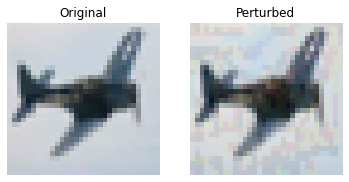

Real class: airplane
Predicted class: airplane with 65.0 confidence


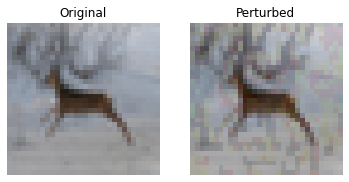

Real class: deer
Predicted class: bird with 26.0 confidence


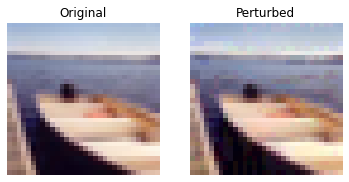

Real class: ship
Predicted class: ship with 59.0 confidence


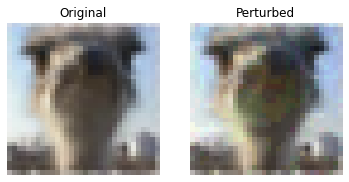

Real class: bird
Predicted class: dog with 25.0 confidence


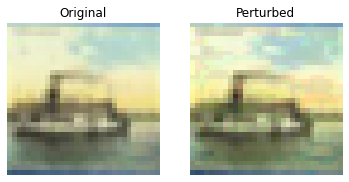

Real class: ship
Predicted class: airplane with 47.0 confidence


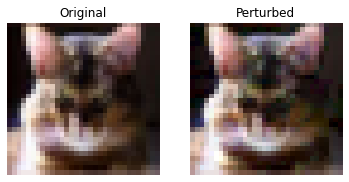

Real class: cat
Predicted class: cat with 28.0 confidence


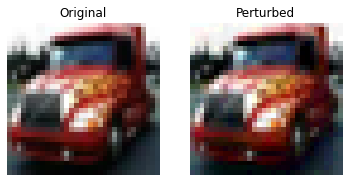

Real class: truck
Predicted class: automobile with 56.0 confidence


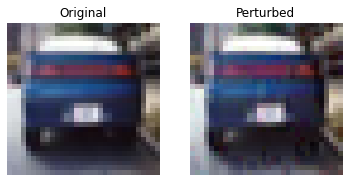

Real class: automobile
Predicted class: automobile with 41.0 confidence


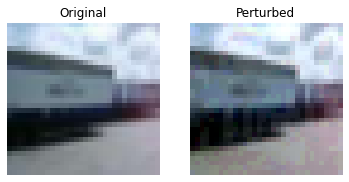

Real class: truck
Predicted class: ship with 40.0 confidence


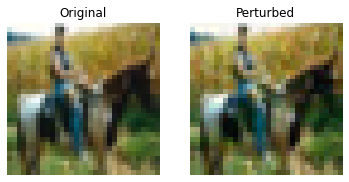

Real class: horse
Predicted class: frog with 44.0 confidence


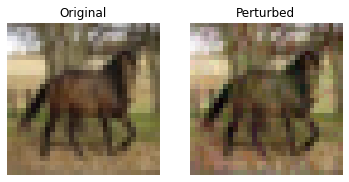

Real class: horse
Predicted class: frog with 43.0 confidence


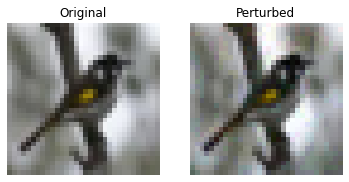

Real class: bird
Predicted class: dog with 27.0 confidence


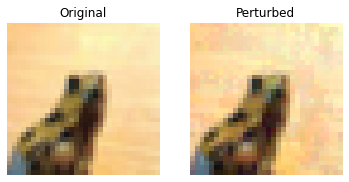

Real class: frog
Predicted class: bird with 33.0 confidence


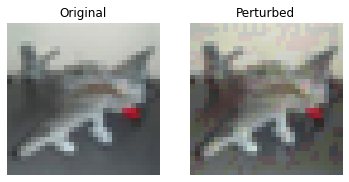

Real class: airplane
Predicted class: frog with 23.0 confidence


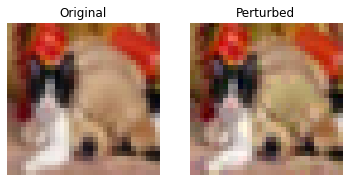

Real class: cat
Predicted class: dog with 31.0 confidence


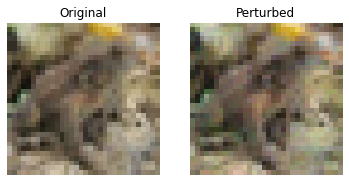

Real class: frog
Predicted class: deer with 20.0 confidence


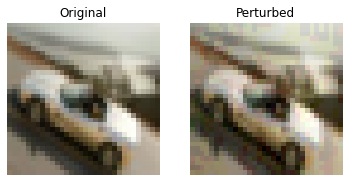

Real class: automobile
Predicted class: frog with 18.0 confidence


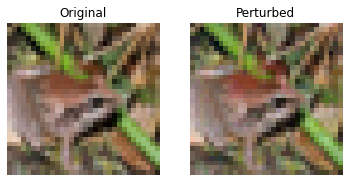

Real class: frog
Predicted class: frog with 41.0 confidence


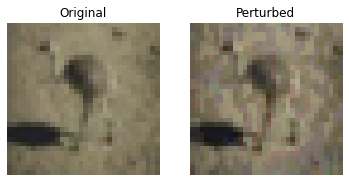

Real class: bird
Predicted class: deer with 27.0 confidence


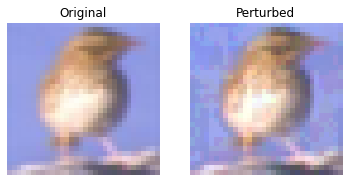

Real class: bird
Predicted class: cat with 22.0 confidence


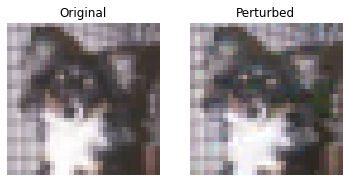

Real class: dog
Predicted class: cat with 25.0 confidence


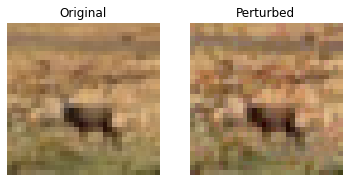

Real class: deer
Predicted class: frog with 34.0 confidence


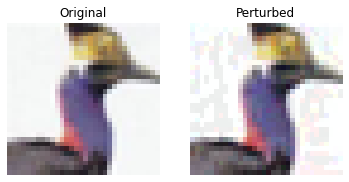

Real class: bird
Predicted class: cat with 21.0 confidence


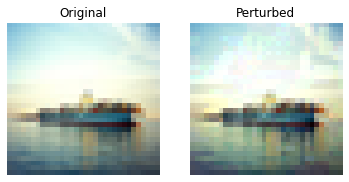

Real class: ship
Predicted class: ship with 55.0 confidence


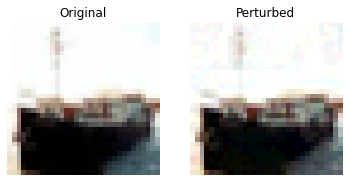

Real class: ship
Predicted class: ship with 76.0 confidence


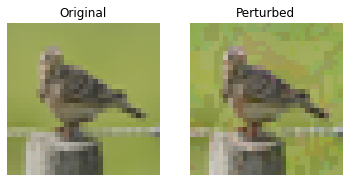

Real class: bird
Predicted class: bird with 37.0 confidence


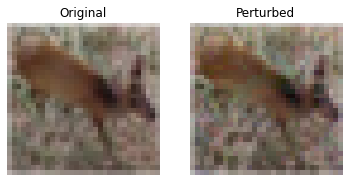

Real class: deer
Predicted class: frog with 45.0 confidence


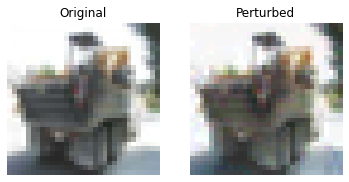

Real class: truck
Predicted class: cat with 28.0 confidence


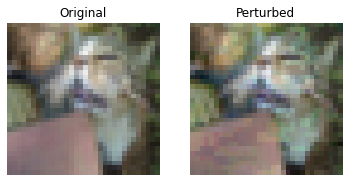

Real class: cat
Predicted class: frog with 23.0 confidence


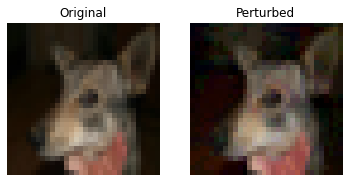

Real class: dog
Predicted class: cat with 26.0 confidence


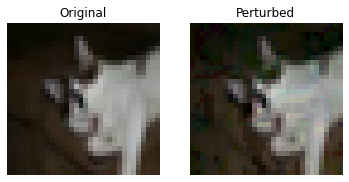

Real class: cat
Predicted class: deer with 21.0 confidence


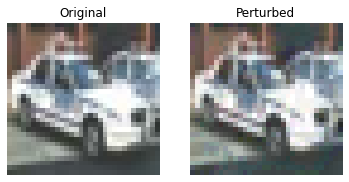

Real class: automobile
Predicted class: ship with 42.0 confidence


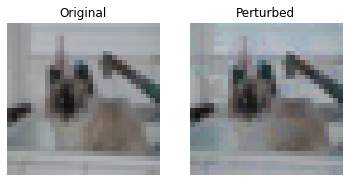

Real class: cat
Predicted class: ship with 47.0 confidence


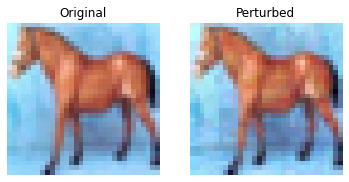

Real class: horse
Predicted class: horse with 21.0 confidence


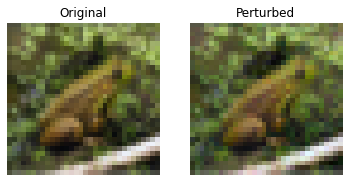

Real class: frog
Predicted class: bird with 31.0 confidence


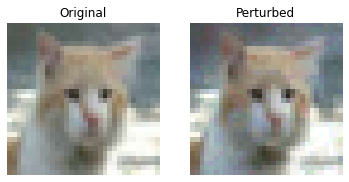

Real class: cat
Predicted class: cat with 23.0 confidence


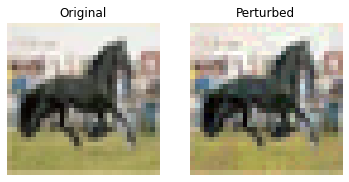

Real class: horse
Predicted class: truck with 36.0 confidence


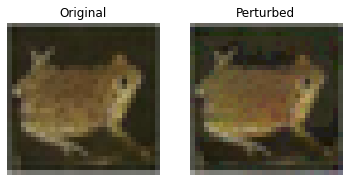

Real class: frog
Predicted class: frog with 44.0 confidence


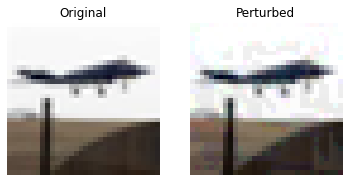

Real class: airplane
Predicted class: airplane with 57.0 confidence


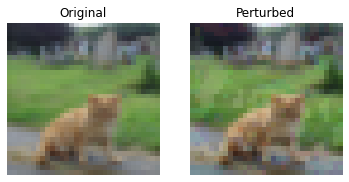

Real class: cat
Predicted class: frog with 38.0 confidence


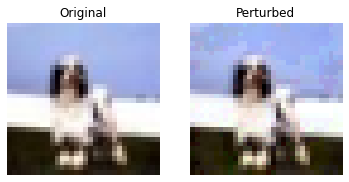

Real class: dog
Predicted class: airplane with 35.0 confidence


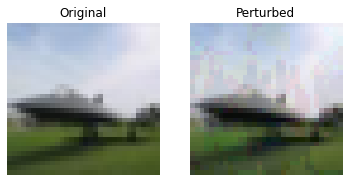

Real class: airplane
Predicted class: ship with 57.0 confidence


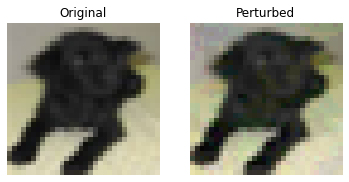

Real class: dog
Predicted class: cat with 26.0 confidence


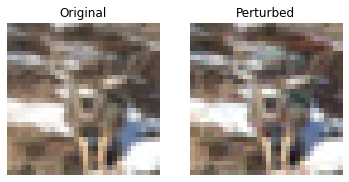

Real class: deer
Predicted class: automobile with 42.0 confidence


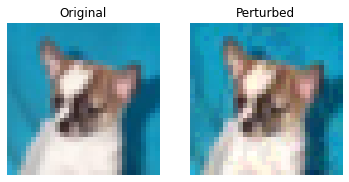

Real class: dog
Predicted class: dog with 25.0 confidence


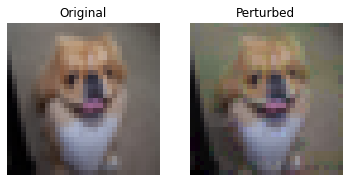

Real class: dog
Predicted class: bird with 26.0 confidence


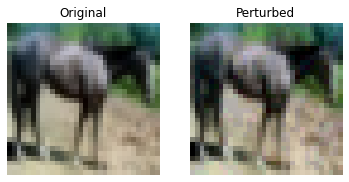

Real class: horse
Predicted class: horse with 56.0 confidence


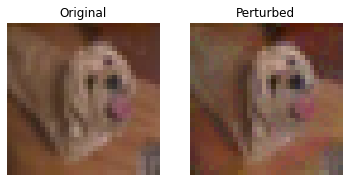

Real class: dog
Predicted class: deer with 23.0 confidence


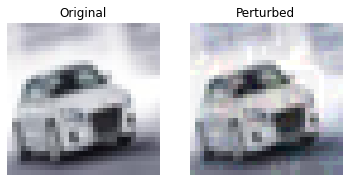

Real class: automobile
Predicted class: automobile with 54.0 confidence
Robust KAF CNN original Accuracy 0.66%
Robust KAF CNN Accuracy0.375%
time: 1min 23s


In [ ]:
# Robustness Accuracy on test set for rob_kaf_cnn model, set plot=True if you want image-wise stats
nfool = 0
nacc = 0
for perturbed_img in rob_kaf_test_adv:
    
    original_idx = find_original_img(perturbed_img)
    nacc += attack_succeed(x_test[original_idx], original_idx, x_test[original_idx], rob_kaf_cnn, plot=False) 
    nfool += attack_succeed(x_test[original_idx], original_idx, perturbed_img, rob_kaf_cnn, plot=True) 

print("Robust KAF CNN original Accuracy {}%\nRobust KAF CNN Accuracy{}%".format(nacc/200, nfool/200))

In [ ]:
from google.colab import files
files.download("/content/rob_kaf_test_pgd.npy")
files.download("/content/rob_kaf_train_pgd.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 10.4 ms
